# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.61755435400219 -3.081009402452157
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [51]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    # tf.nn.sigmoid(1+0.99*(Qs_logits)) --> tf.ones_like(Qs_logits) if Qs_logits >> 1
    #Qs_label = targetQs[1:]
    # g_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
    #                                                                  labels=tf.ones_like(Qs_logits)))
    # g_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
    #                                                                  labels=tf.reshape(
    #                                                                      tf.nn.sigmoid(targetQs[1:]), 
    #                                                                      shape=[-1, 1])))
    g_lossQ = tf.reduce_mean(tf.square(Qs_logits[:-1]-targetQs[1:]))
    #g_lossP = tf.reduce_mean(neg_log_prob_actions * tf.nn.sigmoid(targetQs))
    #g_lossP = tf.reduce_mean(neg_log_prob_actions * targetQs)
    g_lossP = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    #g_loss = g_lossQ + g_lossP
    g_loss = tf.reduce_mean((neg_log_prob_actions[:-1] * targetQs[1:]) +
                            tf.square(Qs_logits[:-1]-targetQs[1:]))
    #g_loss = g_lossP
    #g_loss = g_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, g_lossQ, g_lossP

In [52]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [53]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.g_lossP = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [54]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(9, 4) actions:(9,)
action size:2


In [55]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [56]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [57]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [58]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/300 # success is 200 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_lossQ, g_lossP, g_loss, d_loss, _, _ = sess.run([model.g_lossQ, model.g_lossP, 
                                                           model.g_loss, model.d_loss, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'glossQ:{:.4f}'.format(g_lossQ),
              'glossP:{:.4f}'.format(g_lossP),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 300:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:24.0000 glossQ:0.0002 glossP:0.0088 gloss:0.0090 dloss:0.6983
Episode:1 meanR:16.0000 glossQ:0.0203 glossP:0.1025 gloss:0.1228 dloss:0.7717
Episode:2 meanR:13.6667 glossQ:0.0167 glossP:0.0666 gloss:0.0833 dloss:0.7484
Episode:3 meanR:12.5000 glossQ:0.0085 glossP:0.0320 gloss:0.0405 dloss:0.7217
Episode:4 meanR:12.0000 glossQ:0.0035 glossP:-0.0006 gloss:0.0029 dloss:0.6940
Episode:5 meanR:11.5000 glossQ:0.0000 glossP:-0.0426 gloss:-0.0425 dloss:0.6539
Episode:6 meanR:11.2857 glossQ:0.0017 glossP:-0.0736 gloss:-0.0718 dloss:0.6218
Episode:7 meanR:11.0000 glossQ:0.0084 glossP:-0.1118 gloss:-0.1033 dloss:0.5885
Episode:8 meanR:10.7778 glossQ:0.0175 glossP:-0.1417 gloss:-0.1242 dloss:0.5668
Episode:9 meanR:10.6000 glossQ:0.0309 glossP:-0.1762 gloss:-0.1452 dloss:0.5430
Episode:10 meanR:10.4545 glossQ:0.0471 glossP:-0.2152 gloss:-0.1681 dloss:0.5179
Episode:11 meanR:10.4167 glossQ:0.0157 glossP:-0.0041 gloss:0.0117 dloss:0.6837
Episode:12 meanR:10.3077 glossQ:0.0092 glossP:-0

Episode:103 meanR:43.7100 glossQ:0.0121 glossP:-1.0566 gloss:-1.0445 dloss:0.3692
Episode:104 meanR:44.0200 glossQ:0.0138 glossP:-1.0296 gloss:-1.0158 dloss:0.4067
Episode:105 meanR:44.4500 glossQ:0.0156 glossP:-0.9824 gloss:-0.9668 dloss:0.4629
Episode:106 meanR:44.6300 glossQ:0.0180 glossP:-1.0271 gloss:-1.0091 dloss:0.3420
Episode:107 meanR:44.7900 glossQ:0.0210 glossP:-1.0197 gloss:-0.9987 dloss:0.3283
Episode:108 meanR:44.8900 glossQ:0.0252 glossP:-1.0453 gloss:-1.0201 dloss:0.2947
Episode:109 meanR:44.9900 glossQ:0.0246 glossP:-1.0548 gloss:-1.0303 dloss:0.2935
Episode:110 meanR:45.0500 glossQ:0.0396 glossP:-1.0782 gloss:-1.0386 dloss:0.2708
Episode:111 meanR:45.1700 glossQ:0.0408 glossP:-1.0635 gloss:-1.0227 dloss:0.3082
Episode:112 meanR:45.2400 glossQ:0.0588 glossP:-1.1557 gloss:-1.0969 dloss:0.2643
Episode:113 meanR:45.2900 glossQ:0.0742 glossP:-1.1887 gloss:-1.1145 dloss:0.2440
Episode:114 meanR:45.3100 glossQ:0.1384 glossP:-1.2750 gloss:-1.1366 dloss:0.2229
Episode:115 mean

Episode:204 meanR:28.9200 glossQ:0.0351 glossP:-1.4862 gloss:-1.4511 dloss:0.5716
Episode:205 meanR:29.3000 glossQ:0.0145 glossP:-1.4844 gloss:-1.4698 dloss:0.7587
Episode:206 meanR:30.3500 glossQ:0.0069 glossP:-1.4275 gloss:-1.4206 dloss:1.0455
Episode:207 meanR:30.6400 glossQ:0.0028 glossP:-1.3833 gloss:-1.3805 dloss:0.4895
Episode:208 meanR:30.9600 glossQ:0.0020 glossP:-1.3547 gloss:-1.3528 dloss:0.4670
Episode:209 meanR:31.1100 glossQ:0.0021 glossP:-1.3247 gloss:-1.3226 dloss:0.3540
Episode:210 meanR:31.2700 glossQ:0.0034 glossP:-1.2833 gloss:-1.2799 dloss:0.3356
Episode:211 meanR:31.4000 glossQ:0.0043 glossP:-1.2701 gloss:-1.2657 dloss:0.3614
Episode:212 meanR:31.5300 glossQ:0.0041 glossP:-1.2512 gloss:-1.2471 dloss:0.3250
Episode:213 meanR:31.6900 glossQ:0.0072 glossP:-1.2487 gloss:-1.2415 dloss:0.3248
Episode:214 meanR:31.7900 glossQ:0.0076 glossP:-1.2457 gloss:-1.2382 dloss:0.2761
Episode:215 meanR:31.9100 glossQ:0.0096 glossP:-1.2619 gloss:-1.2523 dloss:0.2995
Episode:216 mean

Episode:307 meanR:29.7000 glossQ:0.0129 glossP:-1.5834 gloss:-1.5705 dloss:1.1042
Episode:308 meanR:29.2800 glossQ:0.7922 glossP:-1.9215 gloss:-1.1293 dloss:0.1566
Episode:309 meanR:29.3700 glossQ:0.0355 glossP:-1.4588 gloss:-1.4233 dloss:0.4176
Episode:310 meanR:29.2700 glossQ:0.0320 glossP:-1.4339 gloss:-1.4020 dloss:0.2647
Episode:311 meanR:29.1800 glossQ:0.0178 glossP:-1.3669 gloss:-1.3490 dloss:0.3017
Episode:312 meanR:29.1500 glossQ:0.0201 glossP:-1.3155 gloss:-1.2954 dloss:0.3048
Episode:313 meanR:29.0500 glossQ:0.0212 glossP:-1.3072 gloss:-1.2860 dloss:0.2616
Episode:314 meanR:29.0500 glossQ:0.0312 glossP:-1.2771 gloss:-1.2459 dloss:0.2775
Episode:315 meanR:28.9700 glossQ:0.0128 glossP:-1.2451 gloss:-1.2323 dloss:0.2564
Episode:316 meanR:29.1800 glossQ:0.0823 glossP:-1.2091 gloss:-1.1268 dloss:0.3845
Episode:317 meanR:33.9800 glossQ:0.0063 glossP:-1.1328 gloss:-1.1265 dloss:2.9078
Episode:318 meanR:34.2800 glossQ:0.0458 glossP:-1.0358 gloss:-0.9900 dloss:0.4183
Episode:319 mean

Episode:409 meanR:50.1400 glossQ:0.0012 glossP:-1.4821 gloss:-1.4809 dloss:1.0536
Episode:410 meanR:50.1100 glossQ:0.0145 glossP:-1.5398 gloss:-1.5253 dloss:0.2366
Episode:411 meanR:50.0000 glossQ:0.0737 glossP:-1.6155 gloss:-1.5418 dloss:0.2114
Episode:412 meanR:49.8400 glossQ:0.1574 glossP:-1.6367 gloss:-1.4793 dloss:0.1728
Episode:413 meanR:49.7900 glossQ:0.0361 glossP:-1.4861 gloss:-1.4500 dloss:0.2122
Episode:414 meanR:49.8100 glossQ:0.0063 glossP:-1.3619 gloss:-1.3556 dloss:0.2820
Episode:415 meanR:51.7600 glossQ:0.0015 glossP:-1.2840 gloss:-1.2825 dloss:1.4574
Episode:416 meanR:51.9400 glossQ:0.0020 glossP:-1.2237 gloss:-1.2217 dloss:0.4878
Episode:417 meanR:47.4900 glossQ:0.0061 glossP:-1.1763 gloss:-1.1701 dloss:0.4798
Episode:418 meanR:47.1900 glossQ:0.0152 glossP:-1.2410 gloss:-1.2258 dloss:0.2331
Episode:419 meanR:46.8800 glossQ:0.0632 glossP:-1.2628 gloss:-1.1996 dloss:0.2082
Episode:420 meanR:46.5600 glossQ:0.0596 glossP:-1.2577 gloss:-1.1981 dloss:0.2151
Episode:421 mean

Episode:512 meanR:39.8100 glossQ:0.0204 glossP:-1.9227 gloss:-1.9023 dloss:0.1994
Episode:513 meanR:39.9000 glossQ:0.0074 glossP:-1.9276 gloss:-1.9202 dloss:0.2736
Episode:514 meanR:39.9900 glossQ:0.0140 glossP:-2.0229 gloss:-2.0089 dloss:0.3642
Episode:515 meanR:37.9800 glossQ:0.0262 glossP:-2.1694 gloss:-2.1432 dloss:0.1579
Episode:516 meanR:37.5400 glossQ:0.0128 glossP:-2.1720 gloss:-2.1593 dloss:0.1681
Episode:517 meanR:37.2000 glossQ:0.0106 glossP:-2.1509 gloss:-2.1403 dloss:0.2613
Episode:518 meanR:37.3500 glossQ:0.0087 glossP:-2.1674 gloss:-2.1587 dloss:0.3352
Episode:519 meanR:37.4100 glossQ:0.0257 glossP:-2.2620 gloss:-2.2363 dloss:0.2012
Episode:520 meanR:37.4500 glossQ:0.0354 glossP:-2.2904 gloss:-2.2549 dloss:0.1908
Episode:521 meanR:37.0300 glossQ:0.0483 glossP:-2.3270 gloss:-2.2787 dloss:0.1578
Episode:522 meanR:35.9800 glossQ:0.0059 glossP:-2.2164 gloss:-2.2105 dloss:0.2639
Episode:523 meanR:36.0700 glossQ:0.0086 glossP:-2.2726 gloss:-2.2641 dloss:0.2449
Episode:524 mean

Episode:617 meanR:39.8700 glossQ:0.0010 glossP:-1.8394 gloss:-1.8384 dloss:0.4139
Episode:618 meanR:39.8400 glossQ:0.0017 glossP:-1.7990 gloss:-1.7973 dloss:0.2885
Episode:619 meanR:39.8600 glossQ:0.0059 glossP:-1.7856 gloss:-1.7797 dloss:0.2191
Episode:620 meanR:39.9100 glossQ:0.0076 glossP:-1.7647 gloss:-1.7571 dloss:0.2367
Episode:621 meanR:39.9300 glossQ:0.0082 glossP:-1.7518 gloss:-1.7436 dloss:0.1860
Episode:622 meanR:39.8900 glossQ:0.0046 glossP:-1.7042 gloss:-1.6996 dloss:0.2212
Episode:623 meanR:39.9700 glossQ:0.0027 glossP:-1.6717 gloss:-1.6690 dloss:0.3031
Episode:624 meanR:40.1200 glossQ:0.0011 glossP:-1.6510 gloss:-1.6500 dloss:0.3267
Episode:625 meanR:40.3500 glossQ:0.0007 glossP:-1.6341 gloss:-1.6334 dloss:0.3658
Episode:626 meanR:40.8700 glossQ:0.0011 glossP:-1.6102 gloss:-1.6091 dloss:0.6138
Episode:627 meanR:41.2900 glossQ:0.0009 glossP:-1.5751 gloss:-1.5742 dloss:0.4850
Episode:628 meanR:41.2400 glossQ:0.0025 glossP:-1.5433 gloss:-1.5408 dloss:0.3178
Episode:629 mean

Episode:719 meanR:30.4100 glossQ:0.0504 glossP:-1.3708 gloss:-1.3204 dloss:0.2827
Episode:720 meanR:30.5200 glossQ:0.0557 glossP:-1.3187 gloss:-1.2630 dloss:0.3309
Episode:721 meanR:30.9700 glossQ:0.0124 glossP:-1.2570 gloss:-1.2446 dloss:0.5022
Episode:722 meanR:31.0500 glossQ:0.0472 glossP:-1.2985 gloss:-1.2513 dloss:0.3005
Episode:723 meanR:30.9200 glossQ:0.0616 glossP:-1.4074 gloss:-1.3458 dloss:0.2212
Episode:724 meanR:32.3600 glossQ:0.0028 glossP:-1.1643 gloss:-1.1615 dloss:1.1461
Episode:725 meanR:32.2500 glossQ:0.0444 glossP:-1.1560 gloss:-1.1115 dloss:0.3080
Episode:726 meanR:31.9000 glossQ:0.0427 glossP:-1.0913 gloss:-1.0486 dloss:0.3578
Episode:727 meanR:33.8200 glossQ:0.0065 glossP:-1.0152 gloss:-1.0088 dloss:1.3958
Episode:728 meanR:33.9000 glossQ:0.0505 glossP:-0.9060 gloss:-0.8555 dloss:0.4032
Episode:729 meanR:33.8300 glossQ:0.1166 glossP:-0.8379 gloss:-0.7213 dloss:0.3604
Episode:730 meanR:34.2700 glossQ:0.0434 glossP:-0.7249 gloss:-0.6815 dloss:0.5124
Episode:731 mean

Episode:819 meanR:42.9200 glossQ:0.0309 glossP:-1.7834 gloss:-1.7525 dloss:0.2199
Episode:820 meanR:43.0000 glossQ:0.0145 glossP:-1.6469 gloss:-1.6324 dloss:0.3904
Episode:821 meanR:42.9700 glossQ:0.0094 glossP:-1.5871 gloss:-1.5777 dloss:0.5170
Episode:822 meanR:43.0400 glossQ:0.0204 glossP:-1.5672 gloss:-1.5467 dloss:0.3408
Episode:823 meanR:43.1000 glossQ:0.0159 glossP:-1.6314 gloss:-1.6154 dloss:0.2481
Episode:824 meanR:41.5400 glossQ:0.0180 glossP:-1.6042 gloss:-1.5862 dloss:0.2337
Episode:825 meanR:41.5200 glossQ:0.0299 glossP:-1.5498 gloss:-1.5200 dloss:0.2663
Episode:826 meanR:42.0900 glossQ:0.0093 glossP:-1.4780 gloss:-1.4687 dloss:0.7455
Episode:827 meanR:39.9100 glossQ:0.0255 glossP:-1.5339 gloss:-1.5084 dloss:0.2889
Episode:828 meanR:39.7000 glossQ:0.0463 glossP:-1.5975 gloss:-1.5512 dloss:0.2196
Episode:829 meanR:39.6200 glossQ:0.0627 glossP:-1.6311 gloss:-1.5684 dloss:0.2108
Episode:830 meanR:39.2100 glossQ:0.0319 glossP:-1.4915 gloss:-1.4596 dloss:0.2475
Episode:831 mean

Episode:926 meanR:33.0100 glossQ:0.0119 glossP:-0.9484 gloss:-0.9365 dloss:0.7567
Episode:927 meanR:32.8600 glossQ:0.1427 glossP:-1.2952 gloss:-1.1525 dloss:0.2150
Episode:928 meanR:32.8800 glossQ:0.0674 glossP:-1.1638 gloss:-1.0964 dloss:0.2751
Episode:929 meanR:33.0600 glossQ:0.0411 glossP:-1.1221 gloss:-1.0811 dloss:0.3601
Episode:930 meanR:33.2700 glossQ:0.0322 glossP:-1.1732 gloss:-1.1410 dloss:0.3955
Episode:931 meanR:32.7800 glossQ:0.0338 glossP:-1.2868 gloss:-1.2530 dloss:0.3503
Episode:932 meanR:33.0500 glossQ:0.0416 glossP:-1.3847 gloss:-1.3431 dloss:0.3680
Episode:933 meanR:33.1100 glossQ:0.0340 glossP:-1.5529 gloss:-1.5188 dloss:0.2367
Episode:934 meanR:33.2000 glossQ:0.0607 glossP:-1.7378 gloss:-1.6771 dloss:0.2469
Episode:935 meanR:33.3000 glossQ:0.0501 glossP:-1.7713 gloss:-1.7213 dloss:0.2377
Episode:936 meanR:33.4700 glossQ:0.0379 glossP:-1.6936 gloss:-1.6558 dloss:0.3202
Episode:937 meanR:33.6300 glossQ:0.0309 glossP:-1.6994 gloss:-1.6685 dloss:0.4597
Episode:938 mean

Episode:1035 meanR:27.2300 glossQ:0.0162 glossP:-1.7243 gloss:-1.7081 dloss:0.4622
Episode:1036 meanR:27.2400 glossQ:0.0117 glossP:-1.7592 gloss:-1.7475 dloss:0.3303
Episode:1037 meanR:26.9000 glossQ:0.0347 glossP:-1.9010 gloss:-1.8664 dloss:0.1727
Episode:1038 meanR:26.5000 glossQ:0.0400 glossP:-1.9272 gloss:-1.8872 dloss:0.1720
Episode:1039 meanR:26.3700 glossQ:0.0121 glossP:-1.7936 gloss:-1.7815 dloss:0.3231
Episode:1040 meanR:26.8100 glossQ:0.0145 glossP:-1.7509 gloss:-1.7364 dloss:0.5668
Episode:1041 meanR:26.7900 glossQ:0.0211 glossP:-1.8445 gloss:-1.8234 dloss:0.2187
Episode:1042 meanR:26.8200 glossQ:0.0234 glossP:-1.8283 gloss:-1.8049 dloss:0.2190
Episode:1043 meanR:26.7400 glossQ:0.0144 glossP:-1.6645 gloss:-1.6501 dloss:0.4719
Episode:1044 meanR:25.2000 glossQ:0.0075 glossP:-1.6070 gloss:-1.5995 dloss:0.4345
Episode:1045 meanR:24.5600 glossQ:0.0246 glossP:-1.6593 gloss:-1.6347 dloss:0.2235
Episode:1046 meanR:24.6300 glossQ:0.0256 glossP:-1.6262 gloss:-1.6005 dloss:0.2561
Epis

Episode:1138 meanR:39.3200 glossQ:0.0058 glossP:-0.4252 gloss:-0.4194 dloss:0.6847
Episode:1139 meanR:39.5500 glossQ:0.0008 glossP:-0.4586 gloss:-0.4578 dloss:0.5304
Episode:1140 meanR:39.1900 glossQ:0.0007 glossP:-0.5659 gloss:-0.5652 dloss:0.4243
Episode:1141 meanR:39.1700 glossQ:0.0037 glossP:-0.7567 gloss:-0.7530 dloss:0.3422
Episode:1142 meanR:39.1900 glossQ:0.0045 glossP:-0.9838 gloss:-0.9793 dloss:0.3049
Episode:1143 meanR:38.8800 glossQ:0.0028 glossP:-1.2334 gloss:-1.2305 dloss:0.2559
Episode:1144 meanR:38.7700 glossQ:0.0009 glossP:-1.4755 gloss:-1.4747 dloss:0.3466
Episode:1145 meanR:38.9800 glossQ:0.0015 glossP:-1.7101 gloss:-1.7087 dloss:0.3944
Episode:1146 meanR:39.1000 glossQ:0.0035 glossP:-1.9138 gloss:-1.9103 dloss:0.3656
Episode:1147 meanR:39.2400 glossQ:0.0049 glossP:-2.0720 gloss:-2.0671 dloss:0.3586
Episode:1148 meanR:39.2300 glossQ:0.0061 glossP:-2.1922 gloss:-2.1861 dloss:0.3160
Episode:1149 meanR:39.0200 glossQ:0.0045 glossP:-2.2689 gloss:-2.2644 dloss:0.4961
Epis

Episode:1241 meanR:31.9900 glossQ:0.0406 glossP:-2.0925 gloss:-2.0519 dloss:0.2094
Episode:1242 meanR:32.0300 glossQ:0.0120 glossP:-1.8536 gloss:-1.8415 dloss:0.2721
Episode:1243 meanR:32.5400 glossQ:0.0033 glossP:-1.6547 gloss:-1.6514 dloss:0.6304
Episode:1244 meanR:32.5000 glossQ:0.0106 glossP:-1.5466 gloss:-1.5360 dloss:0.3179
Episode:1245 meanR:32.3200 glossQ:0.0126 glossP:-1.5235 gloss:-1.5110 dloss:0.2515
Episode:1246 meanR:32.1400 glossQ:0.0241 glossP:-1.4534 gloss:-1.4293 dloss:0.2200
Episode:1247 meanR:31.9500 glossQ:0.0307 glossP:-1.4055 gloss:-1.3748 dloss:0.2042
Episode:1248 meanR:31.8500 glossQ:0.0099 glossP:-1.3189 gloss:-1.3090 dloss:0.2402
Episode:1249 meanR:33.2100 glossQ:0.0015 glossP:-1.2040 gloss:-1.2025 dloss:1.1971
Episode:1250 meanR:32.8600 glossQ:0.0012 glossP:-1.0465 gloss:-1.0452 dloss:0.2940
Episode:1251 meanR:32.5900 glossQ:0.0256 glossP:-1.0462 gloss:-1.0207 dloss:0.2546
Episode:1252 meanR:32.3200 glossQ:0.0225 glossP:-1.0209 gloss:-0.9984 dloss:0.2842
Epis

Episode:1340 meanR:39.7400 glossQ:0.0008 glossP:-1.1766 gloss:-1.1757 dloss:1.4990
Episode:1341 meanR:39.9400 glossQ:0.0056 glossP:-0.9451 gloss:-0.9395 dloss:0.3906
Episode:1342 meanR:39.8700 glossQ:0.0282 glossP:-0.8461 gloss:-0.8180 dloss:0.3232
Episode:1343 meanR:39.4000 glossQ:0.0374 glossP:-0.7875 gloss:-0.7502 dloss:0.3580
Episode:1344 meanR:39.3000 glossQ:0.0471 glossP:-0.8087 gloss:-0.7617 dloss:0.3465
Episode:1345 meanR:39.2700 glossQ:0.0480 glossP:-0.8689 gloss:-0.8210 dloss:0.3251
Episode:1346 meanR:39.3800 glossQ:0.0459 glossP:-0.9745 gloss:-0.9286 dloss:0.3425
Episode:1347 meanR:39.9000 glossQ:0.0615 glossP:-1.0743 gloss:-1.0128 dloss:0.5258
Episode:1348 meanR:41.0100 glossQ:0.0314 glossP:-1.2180 gloss:-1.1866 dloss:0.9078
Episode:1349 meanR:39.6800 glossQ:0.0469 glossP:-1.2155 gloss:-1.1686 dloss:0.4242
Episode:1350 meanR:39.6700 glossQ:0.0063 glossP:-1.0244 gloss:-1.0181 dloss:0.2896
Episode:1351 meanR:39.6700 glossQ:0.0128 glossP:-1.0824 gloss:-1.0696 dloss:0.2394
Epis

Episode:1441 meanR:43.8600 glossQ:0.0007 glossP:-1.6691 gloss:-1.6685 dloss:0.3192
Episode:1442 meanR:43.8000 glossQ:0.0054 glossP:-1.6588 gloss:-1.6534 dloss:0.1654
Episode:1443 meanR:43.7100 glossQ:0.0022 glossP:-1.6325 gloss:-1.6303 dloss:0.1838
Episode:1444 meanR:44.3900 glossQ:0.0015 glossP:-1.5871 gloss:-1.5857 dloss:0.7629
Episode:1445 meanR:44.3700 glossQ:0.0026 glossP:-1.4673 gloss:-1.4647 dloss:0.2179
Episode:1446 meanR:44.2400 glossQ:0.0091 glossP:-1.3566 gloss:-1.3474 dloss:0.2120
Episode:1447 meanR:43.7400 glossQ:0.0082 glossP:-1.3388 gloss:-1.3306 dloss:0.2206
Episode:1448 meanR:42.6300 glossQ:0.0055 glossP:-1.3799 gloss:-1.3745 dloss:0.2315
Episode:1449 meanR:42.5400 glossQ:0.0016 glossP:-1.4628 gloss:-1.4612 dloss:0.3679
Episode:1450 meanR:42.9300 glossQ:0.0007 glossP:-1.4987 gloss:-1.4980 dloss:0.5205
Episode:1451 meanR:42.9500 glossQ:0.0018 glossP:-1.5343 gloss:-1.5325 dloss:0.1987
Episode:1452 meanR:42.9600 glossQ:0.0033 glossP:-1.5485 gloss:-1.5452 dloss:0.1899
Epis

Episode:1542 meanR:37.6200 glossQ:0.0000 glossP:-0.9416 gloss:-0.9416 dloss:0.8505
Episode:1543 meanR:37.9400 glossQ:0.0003 glossP:-0.9310 gloss:-0.9307 dloss:0.4285
Episode:1544 meanR:37.2100 glossQ:0.0045 glossP:-0.9652 gloss:-0.9607 dloss:0.2863
Episode:1545 meanR:37.2000 glossQ:0.0101 glossP:-1.0166 gloss:-1.0065 dloss:0.2760
Episode:1546 meanR:37.2800 glossQ:0.0031 glossP:-1.0010 gloss:-0.9979 dloss:0.3121
Episode:1547 meanR:37.5300 glossQ:0.0012 glossP:-1.0207 gloss:-1.0196 dloss:0.3976
Episode:1548 meanR:38.0100 glossQ:0.0010 glossP:-1.0637 gloss:-1.0627 dloss:0.5229
Episode:1549 meanR:38.3300 glossQ:0.0008 glossP:-1.1017 gloss:-1.1009 dloss:0.5464
Episode:1550 meanR:39.0000 glossQ:0.0008 glossP:-1.1265 gloss:-1.1258 dloss:0.8531
Episode:1551 meanR:40.4300 glossQ:0.0009 glossP:-1.1189 gloss:-1.1179 dloss:1.0230
Episode:1552 meanR:41.2700 glossQ:0.0012 glossP:-1.0704 gloss:-1.0693 dloss:0.6884
Episode:1553 meanR:41.5800 glossQ:0.0018 glossP:-1.0137 gloss:-1.0119 dloss:0.4717
Epis

Episode:1641 meanR:100.0200 glossQ:0.0149 glossP:0.0468 gloss:0.0618 dloss:0.6629
Episode:1642 meanR:100.0400 glossQ:0.0116 glossP:0.1467 gloss:0.1583 dloss:0.7074
Episode:1643 meanR:99.7000 glossQ:0.1169 glossP:0.0538 gloss:0.1707 dloss:0.7513
Episode:1644 meanR:99.6600 glossQ:0.1167 glossP:0.0744 gloss:0.1911 dloss:0.7664
Episode:1645 meanR:99.6000 glossQ:0.0762 glossP:0.0734 gloss:0.1496 dloss:0.7644
Episode:1646 meanR:99.4900 glossQ:0.1961 glossP:-0.0922 gloss:0.1039 dloss:0.6613
Episode:1647 meanR:99.1900 glossQ:0.1798 glossP:-0.1992 gloss:-0.0193 dloss:0.5934
Episode:1648 meanR:98.6300 glossQ:0.1719 glossP:-0.3398 gloss:-0.1679 dloss:0.5153
Episode:1649 meanR:98.0500 glossQ:0.1873 glossP:-0.5808 gloss:-0.3935 dloss:0.4129
Episode:1650 meanR:96.9100 glossQ:0.1458 glossP:-0.5201 gloss:-0.3743 dloss:0.4206
Episode:1651 meanR:95.4500 glossQ:0.1090 glossP:-0.6502 gloss:-0.5411 dloss:0.3613
Episode:1652 meanR:95.5600 glossQ:0.1826 glossP:-0.9198 gloss:-0.7372 dloss:0.7165
Episode:1653 

Episode:1745 meanR:56.3700 glossQ:0.0237 glossP:-1.1941 gloss:-1.1704 dloss:0.8953
Episode:1746 meanR:56.4300 glossQ:0.0306 glossP:-1.3328 gloss:-1.3022 dloss:0.2409
Episode:1747 meanR:56.6100 glossQ:0.0384 glossP:-1.2232 gloss:-1.1848 dloss:0.3182
Episode:1748 meanR:57.2700 glossQ:0.0395 glossP:-1.2280 gloss:-1.1885 dloss:0.5957
Episode:1749 meanR:57.7500 glossQ:0.0287 glossP:-1.1947 gloss:-1.1660 dloss:0.4985
Episode:1750 meanR:57.8000 glossQ:0.0540 glossP:-1.4434 gloss:-1.3893 dloss:0.2246
Episode:1751 meanR:58.0800 glossQ:0.0644 glossP:-1.2316 gloss:-1.1672 dloss:0.3833
Episode:1752 meanR:57.7900 glossQ:0.0329 glossP:-1.1928 gloss:-1.1600 dloss:0.6133
Episode:1753 meanR:59.8700 glossQ:0.0259 glossP:-1.1740 gloss:-1.1481 dloss:1.4076
Episode:1754 meanR:57.0000 glossQ:0.0710 glossP:-1.1710 gloss:-1.1001 dloss:0.3914
Episode:1755 meanR:56.8900 glossQ:0.0762 glossP:-1.1152 gloss:-1.0391 dloss:0.3356
Episode:1756 meanR:57.1800 glossQ:0.0800 glossP:-1.0659 gloss:-0.9858 dloss:0.3977
Epis

Episode:1844 meanR:49.9800 glossQ:0.0908 glossP:-1.4347 gloss:-1.3438 dloss:0.2401
Episode:1845 meanR:49.1600 glossQ:0.0450 glossP:-1.1452 gloss:-1.1001 dloss:0.4246
Episode:1846 meanR:49.4700 glossQ:0.0290 glossP:-1.1718 gloss:-1.1428 dloss:0.4351
Episode:1847 meanR:49.3500 glossQ:0.0720 glossP:-1.3664 gloss:-1.2944 dloss:0.2321
Episode:1848 meanR:48.9100 glossQ:0.0595 glossP:-1.2827 gloss:-1.2232 dloss:0.3328
Episode:1849 meanR:49.0700 glossQ:0.0454 glossP:-1.3045 gloss:-1.2591 dloss:0.6078
Episode:1850 meanR:49.1000 glossQ:0.1198 glossP:-1.7273 gloss:-1.6075 dloss:0.2324
Episode:1851 meanR:49.1200 glossQ:0.0960 glossP:-1.4405 gloss:-1.3444 dloss:0.3974
Episode:1852 meanR:49.7400 glossQ:0.0263 glossP:-1.3389 gloss:-1.3127 dloss:1.0388
Episode:1853 meanR:47.6600 glossQ:0.3150 glossP:-1.7709 gloss:-1.4559 dloss:0.1777
Episode:1854 meanR:47.3700 glossQ:0.7714 glossP:-1.9366 gloss:-1.1652 dloss:0.1674
Episode:1855 meanR:47.5000 glossQ:0.1197 glossP:-1.2860 gloss:-1.1663 dloss:0.4025
Epis

Episode:1943 meanR:46.5000 glossQ:0.0011 glossP:-0.8282 gloss:-0.8271 dloss:0.9747
Episode:1944 meanR:47.1300 glossQ:0.0022 glossP:-0.7582 gloss:-0.7560 dloss:0.5807
Episode:1945 meanR:47.0500 glossQ:0.0019 glossP:-0.6923 gloss:-0.6904 dloss:0.4363
Episode:1946 meanR:46.7000 glossQ:0.0046 glossP:-0.6557 gloss:-0.6511 dloss:0.3652
Episode:1947 meanR:46.7900 glossQ:0.0002 glossP:-0.6227 gloss:-0.6225 dloss:0.4126
Episode:1948 meanR:46.8500 glossQ:0.0008 glossP:-0.6373 gloss:-0.6365 dloss:0.4453
Episode:1949 meanR:47.1800 glossQ:0.0029 glossP:-0.6651 gloss:-0.6622 dloss:0.6669
Episode:1950 meanR:48.9500 glossQ:0.0016 glossP:-0.6740 gloss:-0.6724 dloss:0.9538
Episode:1951 meanR:49.2900 glossQ:0.0142 glossP:-0.6617 gloss:-0.6475 dloss:0.5618
Episode:1952 meanR:48.4300 glossQ:0.0172 glossP:-0.6460 gloss:-0.6288 dloss:0.5005
Episode:1953 meanR:48.8300 glossQ:0.0579 glossP:-0.6557 gloss:-0.5977 dloss:0.4916
Episode:1954 meanR:49.0900 glossQ:0.0512 glossP:-0.6731 gloss:-0.6219 dloss:0.4405
Epis

Episode:2043 meanR:58.9100 glossQ:0.0229 glossP:-1.0009 gloss:-0.9780 dloss:1.1718
Episode:2044 meanR:58.9800 glossQ:0.0346 glossP:-0.9396 gloss:-0.9050 dloss:0.6241
Episode:2045 meanR:59.2700 glossQ:0.0149 glossP:-0.8614 gloss:-0.8465 dloss:0.5276
Episode:2046 meanR:59.5100 glossQ:0.0396 glossP:-0.8461 gloss:-0.8065 dloss:0.4067
Episode:2047 meanR:59.8100 glossQ:0.0164 glossP:-0.7686 gloss:-0.7522 dloss:0.4855
Episode:2048 meanR:59.8000 glossQ:0.0543 glossP:-0.7786 gloss:-0.7243 dloss:0.4148
Episode:2049 meanR:59.0400 glossQ:0.0622 glossP:-0.7851 gloss:-0.7229 dloss:0.3994
Episode:2050 meanR:58.4700 glossQ:0.0257 glossP:-0.7237 gloss:-0.6980 dloss:0.7836
Episode:2051 meanR:57.8700 glossQ:0.1058 glossP:-0.9926 gloss:-0.8868 dloss:0.2899
Episode:2052 meanR:57.4500 glossQ:0.2817 glossP:-1.1244 gloss:-0.8427 dloss:0.2610
Episode:2053 meanR:57.1300 glossQ:0.0448 glossP:-0.8076 gloss:-0.7628 dloss:0.3487
Episode:2054 meanR:56.8700 glossQ:0.4369 glossP:-1.1664 gloss:-0.7295 dloss:0.2464
Epis

Episode:2145 meanR:50.4600 glossQ:0.1295 glossP:-1.0497 gloss:-0.9203 dloss:0.2672
Episode:2146 meanR:51.7100 glossQ:0.0197 glossP:-0.8082 gloss:-0.7885 dloss:0.8986
Episode:2147 meanR:51.2700 glossQ:0.5998 glossP:-1.2492 gloss:-0.6494 dloss:0.2380
Episode:2148 meanR:51.0100 glossQ:0.3006 glossP:-1.0934 gloss:-0.7928 dloss:0.2439
Episode:2149 meanR:50.8100 glossQ:0.0434 glossP:-1.0074 gloss:-0.9640 dloss:0.2695
Episode:2150 meanR:49.5400 glossQ:1.2362 glossP:-1.4238 gloss:-0.1875 dloss:0.2249
Episode:2151 meanR:49.5200 glossQ:0.1206 glossP:-1.1213 gloss:-1.0006 dloss:0.2526
Episode:2152 meanR:49.4900 glossQ:0.3167 glossP:-1.2505 gloss:-0.9338 dloss:0.2145
Episode:2153 meanR:49.4200 glossQ:0.0360 glossP:-1.1757 gloss:-1.1397 dloss:0.2390
Episode:2154 meanR:49.4300 glossQ:0.1811 glossP:-1.3784 gloss:-1.1973 dloss:0.2072
Episode:2155 meanR:49.4600 glossQ:0.2862 glossP:-1.5369 gloss:-1.2507 dloss:0.1991
Episode:2156 meanR:49.8500 glossQ:0.0137 glossP:-1.1899 gloss:-1.1761 dloss:0.4634
Epis

Episode:2249 meanR:45.0400 glossQ:0.0013 glossP:-1.2395 gloss:-1.2382 dloss:0.4708
Episode:2250 meanR:45.8700 glossQ:0.0003 glossP:-1.2265 gloss:-1.2262 dloss:0.7127
Episode:2251 meanR:47.5400 glossQ:0.0006 glossP:-1.1892 gloss:-1.1886 dloss:1.1911
Episode:2252 meanR:49.2500 glossQ:0.0003 glossP:-1.1224 gloss:-1.1221 dloss:1.1540
Episode:2253 meanR:49.6200 glossQ:0.0014 glossP:-1.0191 gloss:-1.0177 dloss:0.4470
Episode:2254 meanR:49.8100 glossQ:0.0166 glossP:-0.9730 gloss:-0.9564 dloss:0.3599
Episode:2255 meanR:49.8500 glossQ:0.0370 glossP:-0.9985 gloss:-0.9615 dloss:0.2896
Episode:2256 meanR:49.5100 glossQ:0.0378 glossP:-0.9589 gloss:-0.9212 dloss:0.3071
Episode:2257 meanR:49.5600 glossQ:0.0245 glossP:-0.8570 gloss:-0.8326 dloss:0.3500
Episode:2258 meanR:51.6200 glossQ:0.0012 glossP:-0.7709 gloss:-0.7698 dloss:1.1010
Episode:2259 meanR:51.6400 glossQ:0.0030 glossP:-0.7177 gloss:-0.7147 dloss:0.3897
Episode:2260 meanR:51.0500 glossQ:0.0361 glossP:-0.7853 gloss:-0.7492 dloss:0.3332
Epis

Episode:2353 meanR:28.5000 glossQ:0.0087 glossP:-1.6355 gloss:-1.6267 dloss:0.3110
Episode:2354 meanR:29.1200 glossQ:0.0012 glossP:-1.5761 gloss:-1.5750 dloss:0.8011
Episode:2355 meanR:29.1900 glossQ:0.0176 glossP:-1.5510 gloss:-1.5334 dloss:0.2724
Episode:2356 meanR:29.2000 glossQ:0.0418 glossP:-1.5784 gloss:-1.5366 dloss:0.2409
Episode:2357 meanR:29.1300 glossQ:0.0446 glossP:-1.5202 gloss:-1.4756 dloss:0.2209
Episode:2358 meanR:27.1300 glossQ:0.0188 glossP:-1.4273 gloss:-1.4085 dloss:0.2555
Episode:2359 meanR:27.2200 glossQ:0.0014 glossP:-1.3633 gloss:-1.3619 dloss:0.3536
Episode:2360 meanR:30.2700 glossQ:0.0013 glossP:-1.3622 gloss:-1.3609 dloss:2.2472
Episode:2361 meanR:30.3200 glossQ:0.0043 glossP:-1.2404 gloss:-1.2362 dloss:0.4051
Episode:2362 meanR:29.8900 glossQ:0.0172 glossP:-1.1801 gloss:-1.1629 dloss:0.2843
Episode:2363 meanR:29.7900 glossQ:0.0284 glossP:-1.1274 gloss:-1.0990 dloss:0.2577
Episode:2364 meanR:29.8000 glossQ:0.0356 glossP:-1.0823 gloss:-1.0467 dloss:0.2750
Epis

Episode:2453 meanR:34.3400 glossQ:0.1214 glossP:-1.8732 gloss:-1.7518 dloss:0.2019
Episode:2454 meanR:33.5500 glossQ:0.2036 glossP:-1.8544 gloss:-1.6508 dloss:0.1847
Episode:2455 meanR:33.4300 glossQ:0.1440 glossP:-1.7876 gloss:-1.6436 dloss:0.1696
Episode:2456 meanR:33.4500 glossQ:0.0351 glossP:-1.4373 gloss:-1.4022 dloss:0.2634
Episode:2457 meanR:33.4000 glossQ:0.2440 glossP:-1.7612 gloss:-1.5172 dloss:0.1714
Episode:2458 meanR:33.3100 glossQ:0.2143 glossP:-1.7626 gloss:-1.5483 dloss:0.1710
Episode:2459 meanR:33.1600 glossQ:0.0441 glossP:-1.4932 gloss:-1.4491 dloss:0.2459
Episode:2460 meanR:30.2700 glossQ:0.0280 glossP:-1.5302 gloss:-1.5022 dloss:0.3258
Episode:2461 meanR:29.9800 glossQ:0.1261 glossP:-1.7839 gloss:-1.6579 dloss:0.1861
Episode:2462 meanR:29.9200 glossQ:0.1086 glossP:-1.7761 gloss:-1.6676 dloss:0.2034
Episode:2463 meanR:30.0200 glossQ:0.0323 glossP:-1.5491 gloss:-1.5168 dloss:0.2883
Episode:2464 meanR:30.1800 glossQ:0.0175 glossP:-1.4823 gloss:-1.4648 dloss:0.3471
Epis

Episode:2553 meanR:39.8500 glossQ:0.0080 glossP:-1.0939 gloss:-1.0859 dloss:0.3924
Episode:2554 meanR:40.3700 glossQ:0.0085 glossP:-1.1225 gloss:-1.1141 dloss:0.5326
Episode:2555 meanR:40.4300 glossQ:0.0278 glossP:-1.3130 gloss:-1.2852 dloss:0.2477
Episode:2556 meanR:40.3400 glossQ:0.0680 glossP:-1.4630 gloss:-1.3950 dloss:0.2005
Episode:2557 meanR:40.6000 glossQ:0.0185 glossP:-1.2896 gloss:-1.2711 dloss:0.3745
Episode:2558 meanR:40.9900 glossQ:0.0064 glossP:-1.2653 gloss:-1.2589 dloss:0.4542
Episode:2559 meanR:41.0400 glossQ:0.0293 glossP:-1.3791 gloss:-1.3499 dloss:0.2873
Episode:2560 meanR:40.9100 glossQ:0.0476 glossP:-1.5050 gloss:-1.4574 dloss:0.2316
Episode:2561 meanR:41.0400 glossQ:0.0190 glossP:-1.4172 gloss:-1.3982 dloss:0.2989
Episode:2562 meanR:42.5500 glossQ:0.0058 glossP:-1.4489 gloss:-1.4430 dloss:1.2801
Episode:2563 meanR:42.6800 glossQ:0.0224 glossP:-1.4299 gloss:-1.4075 dloss:0.3817
Episode:2564 meanR:42.5400 glossQ:0.0355 glossP:-1.4836 gloss:-1.4481 dloss:0.2474
Epis

Episode:2654 meanR:51.8500 glossQ:0.0235 glossP:-1.9095 gloss:-1.8860 dloss:1.3324
Episode:2655 meanR:51.7900 glossQ:0.0919 glossP:-1.9245 gloss:-1.8326 dloss:0.1617
Episode:2656 meanR:51.7700 glossQ:0.1973 glossP:-1.8879 gloss:-1.6906 dloss:0.1538
Episode:2657 meanR:51.5500 glossQ:0.0949 glossP:-1.7962 gloss:-1.7013 dloss:0.2021
Episode:2658 meanR:51.9600 glossQ:0.0017 glossP:-1.4585 gloss:-1.4568 dloss:0.7576
Episode:2659 meanR:51.9400 glossQ:0.0369 glossP:-1.4856 gloss:-1.4488 dloss:0.2672
Episode:2660 meanR:51.8900 glossQ:0.0659 glossP:-1.4749 gloss:-1.4090 dloss:0.1944
Episode:2661 meanR:51.8000 glossQ:0.0322 glossP:-1.3386 gloss:-1.3065 dloss:0.2410
Episode:2662 meanR:50.4100 glossQ:0.0051 glossP:-1.2354 gloss:-1.2303 dloss:0.3134
Episode:2663 meanR:50.7800 glossQ:0.0005 glossP:-1.2455 gloss:-1.2450 dloss:0.6049
Episode:2664 meanR:51.0600 glossQ:0.0009 glossP:-1.2040 gloss:-1.2031 dloss:0.4345
Episode:2665 meanR:51.0700 glossQ:0.0293 glossP:-1.3023 gloss:-1.2730 dloss:0.2539
Epis

Episode:2757 meanR:37.0700 glossQ:0.0251 glossP:-1.2945 gloss:-1.2694 dloss:0.2613
Episode:2758 meanR:36.4300 glossQ:0.0231 glossP:-1.2868 gloss:-1.2637 dloss:0.3120
Episode:2759 meanR:36.6700 glossQ:0.0086 glossP:-1.2449 gloss:-1.2362 dloss:0.4293
Episode:2760 meanR:37.5800 glossQ:0.0060 glossP:-1.2939 gloss:-1.2879 dloss:0.7875
Episode:2761 meanR:37.8500 glossQ:0.0126 glossP:-1.2747 gloss:-1.2621 dloss:0.4178
Episode:2762 meanR:37.7400 glossQ:0.0423 glossP:-1.3989 gloss:-1.3565 dloss:0.2332
Episode:2763 meanR:37.1600 glossQ:0.0448 glossP:-1.4069 gloss:-1.3621 dloss:0.2395
Episode:2764 meanR:37.3100 glossQ:0.0078 glossP:-1.2026 gloss:-1.1947 dloss:0.5218
Episode:2765 meanR:37.6400 glossQ:0.0167 glossP:-1.1949 gloss:-1.1783 dloss:0.4579
Episode:2766 meanR:37.7400 glossQ:0.0261 glossP:-1.3105 gloss:-1.2845 dloss:0.2860
Episode:2767 meanR:37.7000 glossQ:0.0376 glossP:-1.4059 gloss:-1.3683 dloss:0.2596
Episode:2768 meanR:37.5700 glossQ:0.0261 glossP:-1.3308 gloss:-1.3047 dloss:0.2910
Epis

Episode:2857 meanR:36.0200 glossQ:0.0558 glossP:-1.7727 gloss:-1.7169 dloss:0.2207
Episode:2858 meanR:35.8600 glossQ:0.1715 glossP:-1.9777 gloss:-1.8061 dloss:0.1633
Episode:2859 meanR:35.8000 glossQ:0.0103 glossP:-1.5816 gloss:-1.5713 dloss:0.4026
Episode:2860 meanR:34.8700 glossQ:0.5276 glossP:-2.0879 gloss:-1.5603 dloss:0.1533
Episode:2861 meanR:34.6200 glossQ:0.0440 glossP:-1.7728 gloss:-1.7288 dloss:0.2371
Episode:2862 meanR:34.5900 glossQ:0.0821 glossP:-2.0694 gloss:-1.9872 dloss:0.1797
Episode:2863 meanR:34.5200 glossQ:0.2030 glossP:-2.1713 gloss:-1.9683 dloss:0.1491
Episode:2864 meanR:34.6500 glossQ:0.0016 glossP:-1.8244 gloss:-1.8228 dloss:0.7310
Episode:2865 meanR:34.2300 glossQ:0.3661 glossP:-2.1795 gloss:-1.8135 dloss:0.1397
Episode:2866 meanR:34.4600 glossQ:0.0036 glossP:-1.7359 gloss:-1.7323 dloss:0.4639
Episode:2867 meanR:34.3900 glossQ:0.1379 glossP:-2.0955 gloss:-1.9576 dloss:0.1804
Episode:2868 meanR:34.2500 glossQ:0.1769 glossP:-2.0423 gloss:-1.8655 dloss:0.1518
Epis

Episode:2958 meanR:26.2000 glossQ:0.0619 glossP:-1.7446 gloss:-1.6827 dloss:0.2462
Episode:2959 meanR:25.9600 glossQ:0.0544 glossP:-1.6052 gloss:-1.5507 dloss:0.2173
Episode:2960 meanR:26.4600 glossQ:0.0091 glossP:-1.4485 gloss:-1.4394 dloss:0.5372
Episode:2961 meanR:26.6800 glossQ:0.0389 glossP:-1.4931 gloss:-1.4542 dloss:0.4058
Episode:2962 meanR:26.7900 glossQ:0.0425 glossP:-1.5893 gloss:-1.5469 dloss:0.2805
Episode:2963 meanR:26.9200 glossQ:0.0423 glossP:-1.5242 gloss:-1.4819 dloss:0.2744
Episode:2964 meanR:26.4900 glossQ:0.0440 glossP:-1.4047 gloss:-1.3606 dloss:0.3410
Episode:2965 meanR:27.0800 glossQ:0.0360 glossP:-1.2509 gloss:-1.2149 dloss:0.5641
Episode:2966 meanR:27.0800 glossQ:0.0103 glossP:-1.1577 gloss:-1.1474 dloss:0.4289
Episode:2967 meanR:27.1800 glossQ:0.0497 glossP:-1.2197 gloss:-1.1701 dloss:0.2941
Episode:2968 meanR:27.3500 glossQ:0.0495 glossP:-1.2056 gloss:-1.1561 dloss:0.3187
Episode:2969 meanR:27.4700 glossQ:0.0355 glossP:-1.1616 gloss:-1.1261 dloss:0.3395
Epis

Episode:3062 meanR:50.5300 glossQ:0.0020 glossP:-1.3877 gloss:-1.3857 dloss:0.5554
Episode:3063 meanR:50.8700 glossQ:0.0002 glossP:-1.3522 gloss:-1.3520 dloss:0.5047
Episode:3064 meanR:50.8000 glossQ:0.0493 glossP:-1.4170 gloss:-1.3677 dloss:0.2922
Episode:3065 meanR:50.2600 glossQ:0.0723 glossP:-1.4815 gloss:-1.4092 dloss:0.2107
Episode:3066 meanR:50.0100 glossQ:0.0594 glossP:-1.4223 gloss:-1.3629 dloss:0.2644
Episode:3067 meanR:50.1500 glossQ:0.0214 glossP:-1.2894 gloss:-1.2679 dloss:0.3744
Episode:3068 meanR:51.5400 glossQ:0.0019 glossP:-1.2481 gloss:-1.2462 dloss:1.1559
Episode:3069 meanR:51.6200 glossQ:0.0002 glossP:-1.1821 gloss:-1.1818 dloss:0.3826
Episode:3070 meanR:50.2600 glossQ:0.0217 glossP:-1.2476 gloss:-1.2259 dloss:0.2412
Episode:3071 meanR:49.7400 glossQ:0.0270 glossP:-1.2147 gloss:-1.1876 dloss:0.2572
Episode:3072 meanR:49.8600 glossQ:0.0059 glossP:-1.0913 gloss:-1.0853 dloss:0.3448
Episode:3073 meanR:51.1600 glossQ:0.0005 glossP:-1.0566 gloss:-1.0561 dloss:0.9632
Epis

Episode:3164 meanR:32.3200 glossQ:0.0003 glossP:-1.4517 gloss:-1.4514 dloss:0.4176
Episode:3165 meanR:32.5700 glossQ:0.0004 glossP:-1.4692 gloss:-1.4688 dloss:0.3896
Episode:3166 meanR:32.6300 glossQ:0.0008 glossP:-1.4812 gloss:-1.4804 dloss:0.3033
Episode:3167 meanR:32.4800 glossQ:0.0095 glossP:-1.5216 gloss:-1.5121 dloss:0.2651
Episode:3168 meanR:31.0100 glossQ:0.0146 glossP:-1.5590 gloss:-1.5444 dloss:0.2409
Episode:3169 meanR:30.8200 glossQ:0.0102 glossP:-1.5564 gloss:-1.5462 dloss:0.2413
Episode:3170 meanR:30.9100 glossQ:0.0024 glossP:-1.5543 gloss:-1.5519 dloss:0.2798
Episode:3171 meanR:31.2700 glossQ:0.0005 glossP:-1.5708 gloss:-1.5702 dloss:0.5013
Episode:3172 meanR:31.5000 glossQ:0.0009 glossP:-1.5738 gloss:-1.5729 dloss:0.5017
Episode:3173 meanR:30.3500 glossQ:0.0022 glossP:-1.5668 gloss:-1.5646 dloss:0.3636
Episode:3174 meanR:29.9700 glossQ:0.0097 glossP:-1.5886 gloss:-1.5789 dloss:0.2405
Episode:3175 meanR:29.8500 glossQ:0.0168 glossP:-1.6100 gloss:-1.5931 dloss:0.2555
Epis

Episode:3263 meanR:38.6400 glossQ:0.0006 glossP:-1.3500 gloss:-1.3494 dloss:0.8587
Episode:3264 meanR:38.3900 glossQ:0.0285 glossP:-1.3862 gloss:-1.3577 dloss:0.2450
Episode:3265 meanR:38.1300 glossQ:0.0526 glossP:-1.4506 gloss:-1.3980 dloss:0.2047
Episode:3266 meanR:38.0600 glossQ:0.0391 glossP:-1.4012 gloss:-1.3621 dloss:0.2578
Episode:3267 meanR:38.9400 glossQ:0.0013 glossP:-1.2882 gloss:-1.2869 dloss:0.8302
Episode:3268 meanR:39.1500 glossQ:0.0044 glossP:-1.2636 gloss:-1.2592 dloss:0.3928
Episode:3269 meanR:39.0900 glossQ:0.0302 glossP:-1.3401 gloss:-1.3099 dloss:0.2164
Episode:3270 meanR:38.9900 glossQ:0.0263 glossP:-1.3162 gloss:-1.2900 dloss:0.2259
Episode:3271 meanR:38.6500 glossQ:0.0131 glossP:-1.2528 gloss:-1.2398 dloss:0.2653
Episode:3272 meanR:38.7900 glossQ:0.0042 glossP:-1.2198 gloss:-1.2156 dloss:0.5529
Episode:3273 meanR:39.2000 glossQ:0.0100 glossP:-1.2334 gloss:-1.2234 dloss:0.6085
Episode:3274 meanR:39.4200 glossQ:0.0354 glossP:-1.2631 gloss:-1.2278 dloss:0.3999
Epis

Episode:3364 meanR:64.6300 glossQ:0.1065 glossP:-1.0242 gloss:-0.9177 dloss:0.3668
Episode:3365 meanR:65.1100 glossQ:0.0540 glossP:-1.0179 gloss:-0.9639 dloss:0.5079
Episode:3366 meanR:65.0200 glossQ:0.0802 glossP:-1.2839 gloss:-1.2037 dloss:0.2184
Episode:3367 meanR:64.0300 glossQ:0.4533 glossP:-1.5425 gloss:-1.0892 dloss:0.1957
Episode:3368 meanR:63.7400 glossQ:0.1421 glossP:-1.4957 gloss:-1.3535 dloss:0.1937
Episode:3369 meanR:63.9300 glossQ:0.1048 glossP:-1.3975 gloss:-1.2927 dloss:0.3427
Episode:3370 meanR:63.8900 glossQ:0.1818 glossP:-1.6419 gloss:-1.4601 dloss:0.1736
Episode:3371 meanR:63.7900 glossQ:0.2679 glossP:-1.8039 gloss:-1.5360 dloss:0.1533
Episode:3372 meanR:63.2300 glossQ:0.8989 glossP:-2.0094 gloss:-1.1105 dloss:0.1681
Episode:3373 meanR:62.6300 glossQ:0.0803 glossP:-1.8803 gloss:-1.7999 dloss:0.2101
Episode:3374 meanR:62.3200 glossQ:0.6520 glossP:-2.0820 gloss:-1.4300 dloss:0.1527
Episode:3375 meanR:62.1900 glossQ:0.5741 glossP:-2.1731 gloss:-1.5990 dloss:0.1401
Epis

Episode:3477 meanR:31.0300 glossQ:0.1037 glossP:-2.4601 gloss:-2.3564 dloss:0.1859
Episode:3478 meanR:31.9800 glossQ:0.0024 glossP:-2.2403 gloss:-2.2379 dloss:1.2115
Episode:3479 meanR:31.9900 glossQ:0.1739 glossP:-2.3019 gloss:-2.1280 dloss:0.1479
Episode:3480 meanR:32.1400 glossQ:0.0136 glossP:-2.0249 gloss:-2.0113 dloss:0.3464
Episode:3481 meanR:32.2100 glossQ:0.0335 glossP:-1.9385 gloss:-1.9050 dloss:0.2278
Episode:3482 meanR:31.9900 glossQ:0.0813 glossP:-1.9706 gloss:-1.8892 dloss:0.1897
Episode:3483 meanR:32.0200 glossQ:0.0553 glossP:-1.8362 gloss:-1.7809 dloss:0.2093
Episode:3484 meanR:32.0500 glossQ:0.0366 glossP:-1.7330 gloss:-1.6963 dloss:0.1850
Episode:3485 meanR:34.6800 glossQ:0.0005 glossP:-1.6256 gloss:-1.6251 dloss:2.2807
Episode:3486 meanR:34.7200 glossQ:0.0241 glossP:-1.5557 gloss:-1.5316 dloss:0.2338
Episode:3487 meanR:34.7000 glossQ:0.0558 glossP:-1.4158 gloss:-1.3600 dloss:0.1900
Episode:3488 meanR:34.6600 glossQ:0.0240 glossP:-1.2581 gloss:-1.2341 dloss:0.2315
Epis

Episode:3583 meanR:35.6300 glossQ:0.0090 glossP:-1.8036 gloss:-1.7947 dloss:0.2188
Episode:3584 meanR:35.6000 glossQ:0.2068 glossP:-2.0257 gloss:-1.8189 dloss:0.1516
Episode:3585 meanR:32.9400 glossQ:0.0361 glossP:-1.8772 gloss:-1.8412 dloss:0.1636
Episode:3586 meanR:32.8500 glossQ:0.1177 glossP:-1.9623 gloss:-1.8446 dloss:0.1421
Episode:3587 meanR:32.8400 glossQ:0.2047 glossP:-2.0825 gloss:-1.8778 dloss:0.1503
Episode:3588 meanR:32.8200 glossQ:0.1939 glossP:-2.1086 gloss:-1.9146 dloss:0.1704
Episode:3589 meanR:32.3600 glossQ:0.1925 glossP:-2.0553 gloss:-1.8628 dloss:0.1398
Episode:3590 meanR:32.4600 glossQ:0.0150 glossP:-1.8676 gloss:-1.8526 dloss:0.2994
Episode:3591 meanR:32.4100 glossQ:0.4792 glossP:-2.1179 gloss:-1.6387 dloss:0.1289
Episode:3592 meanR:32.3800 glossQ:0.3602 glossP:-2.0993 gloss:-1.7391 dloss:0.1495
Episode:3593 meanR:32.3300 glossQ:0.3272 glossP:-2.0734 gloss:-1.7462 dloss:0.1383
Episode:3594 meanR:32.2600 glossQ:0.6648 glossP:-2.1894 gloss:-1.5246 dloss:0.1515
Epis

Episode:3686 meanR:36.3200 glossQ:0.0129 glossP:-1.0093 gloss:-0.9963 dloss:0.4770
Episode:3687 meanR:37.8100 glossQ:0.0035 glossP:-0.9804 gloss:-0.9768 dloss:0.9696
Episode:3688 meanR:39.2200 glossQ:0.0022 glossP:-0.9045 gloss:-0.9023 dloss:0.9074
Episode:3689 meanR:40.1000 glossQ:0.0009 glossP:-0.7763 gloss:-0.7754 dloss:0.6450
Episode:3690 meanR:40.2800 glossQ:0.0037 glossP:-0.6470 gloss:-0.6433 dloss:0.4680
Episode:3691 meanR:40.4600 glossQ:0.0056 glossP:-0.5676 gloss:-0.5620 dloss:0.4358
Episode:3692 meanR:40.6400 glossQ:0.0058 glossP:-0.5471 gloss:-0.5413 dloss:0.4480
Episode:3693 meanR:40.9400 glossQ:0.0077 glossP:-0.6013 gloss:-0.5937 dloss:0.4633
Episode:3694 meanR:41.4600 glossQ:0.0017 glossP:-0.6972 gloss:-0.6956 dloss:0.5194
Episode:3695 meanR:41.6800 glossQ:0.0013 glossP:-0.8359 gloss:-0.8346 dloss:0.3899
Episode:3696 meanR:41.6900 glossQ:0.0038 glossP:-1.0615 gloss:-1.0577 dloss:0.2665
Episode:3697 meanR:42.1000 glossQ:0.0027 glossP:-1.4316 gloss:-1.4289 dloss:0.4641
Epis

Episode:3794 meanR:32.1500 glossQ:0.0084 glossP:-2.0058 gloss:-1.9974 dloss:0.9816
Episode:3795 meanR:31.9800 glossQ:0.0290 glossP:-2.0621 gloss:-2.0331 dloss:0.1997
Episode:3796 meanR:31.9800 glossQ:0.0542 glossP:-1.9712 gloss:-1.9170 dloss:0.1893
Episode:3797 meanR:31.6100 glossQ:0.0482 glossP:-1.8471 gloss:-1.7989 dloss:0.1803
Episode:3798 meanR:31.1900 glossQ:0.0161 glossP:-1.7424 gloss:-1.7263 dloss:0.2364
Episode:3799 meanR:30.7700 glossQ:0.0063 glossP:-1.6087 gloss:-1.6023 dloss:0.3029
Episode:3800 meanR:30.3200 glossQ:0.0008 glossP:-1.5325 gloss:-1.5317 dloss:0.6109
Episode:3801 meanR:29.9100 glossQ:0.0236 glossP:-1.5445 gloss:-1.5209 dloss:0.2107
Episode:3802 meanR:29.8500 glossQ:0.0409 glossP:-1.5494 gloss:-1.5085 dloss:0.2171
Episode:3803 meanR:29.7500 glossQ:0.0419 glossP:-1.5070 gloss:-1.4651 dloss:0.2194
Episode:3804 meanR:29.3200 glossQ:0.0201 glossP:-1.4153 gloss:-1.3951 dloss:0.2623
Episode:3805 meanR:29.3900 glossQ:0.0018 glossP:-1.3408 gloss:-1.3390 dloss:0.3472
Epis

Episode:3894 meanR:41.2200 glossQ:0.0004 glossP:-0.9843 gloss:-0.9840 dloss:0.3864
Episode:3895 meanR:41.3000 glossQ:0.0046 glossP:-0.9936 gloss:-0.9891 dloss:0.3218
Episode:3896 meanR:41.2900 glossQ:0.0137 glossP:-1.0368 gloss:-1.0230 dloss:0.2642
Episode:3897 meanR:41.4500 glossQ:0.0007 glossP:-1.0034 gloss:-1.0026 dloss:0.3501
Episode:3898 meanR:43.4700 glossQ:0.0006 glossP:-1.0228 gloss:-1.0222 dloss:1.2965
Episode:3899 meanR:43.3300 glossQ:0.0020 glossP:-0.9241 gloss:-0.9221 dloss:0.2890
Episode:3900 meanR:42.9200 glossQ:0.0015 glossP:-0.9774 gloss:-0.9759 dloss:0.3445
Episode:3901 meanR:42.9500 glossQ:0.0200 glossP:-1.0725 gloss:-1.0525 dloss:0.2836
Episode:3902 meanR:42.9700 glossQ:0.0162 glossP:-1.0783 gloss:-1.0622 dloss:0.2830
Episode:3903 meanR:43.1100 glossQ:0.0074 glossP:-1.0343 gloss:-1.0269 dloss:0.3517
Episode:3904 meanR:43.4600 glossQ:0.0023 glossP:-1.0309 gloss:-1.0286 dloss:0.4815
Episode:3905 meanR:43.6200 glossQ:0.0033 glossP:-1.0639 gloss:-1.0607 dloss:0.4459
Epis

Episode:3998 meanR:28.2600 glossQ:0.2400 glossP:-1.9207 gloss:-1.6807 dloss:0.1634
Episode:3999 meanR:28.2300 glossQ:0.6119 glossP:-1.9303 gloss:-1.3184 dloss:0.1516
Episode:4000 meanR:28.0600 glossQ:0.5647 glossP:-2.1453 gloss:-1.5806 dloss:0.1510
Episode:4001 meanR:27.9600 glossQ:0.2241 glossP:-1.6190 gloss:-1.3949 dloss:0.1307
Episode:4002 meanR:27.8700 glossQ:0.3799 glossP:-1.6425 gloss:-1.2626 dloss:0.1397
Episode:4003 meanR:28.2700 glossQ:0.0085 glossP:-2.0025 gloss:-1.9940 dloss:0.7320
Episode:4004 meanR:27.8000 glossQ:0.3266 glossP:-2.1229 gloss:-1.7963 dloss:0.1372
Episode:4005 meanR:27.4200 glossQ:0.2466 glossP:-2.2236 gloss:-1.9770 dloss:0.1601
Episode:4006 meanR:27.3500 glossQ:0.0127 glossP:-1.9077 gloss:-1.8950 dloss:0.2738
Episode:4007 meanR:27.1200 glossQ:0.2488 glossP:-1.7246 gloss:-1.4758 dloss:0.1300
Episode:4008 meanR:27.0700 glossQ:0.0567 glossP:-1.9748 gloss:-1.9180 dloss:0.1993
Episode:4009 meanR:27.0400 glossQ:0.0328 glossP:-1.9833 gloss:-1.9505 dloss:0.2188
Epis

Episode:4104 meanR:36.8800 glossQ:0.0004 glossP:-1.6381 gloss:-1.6377 dloss:0.2311
Episode:4105 meanR:36.8900 glossQ:0.0005 glossP:-1.6856 gloss:-1.6851 dloss:0.1795
Episode:4106 meanR:36.9000 glossQ:0.0005 glossP:-1.7412 gloss:-1.7407 dloss:0.2792
Episode:4107 meanR:37.2000 glossQ:0.0007 glossP:-1.7810 gloss:-1.7802 dloss:0.4006
Episode:4108 meanR:37.5600 glossQ:0.0008 glossP:-1.8054 gloss:-1.8045 dloss:0.5160
Episode:4109 meanR:37.9200 glossQ:0.0008 glossP:-1.8169 gloss:-1.8161 dloss:0.5353
Episode:4110 meanR:38.0800 glossQ:0.0007 glossP:-1.8205 gloss:-1.8198 dloss:0.2891
Episode:4111 meanR:38.1600 glossQ:0.0006 glossP:-1.8168 gloss:-1.8162 dloss:0.2273
Episode:4112 meanR:38.2200 glossQ:0.0005 glossP:-1.8075 gloss:-1.8069 dloss:0.2362
Episode:4113 meanR:38.0500 glossQ:0.0006 glossP:-1.7955 gloss:-1.7949 dloss:0.3233
Episode:4114 meanR:38.3500 glossQ:0.0006 glossP:-1.7810 gloss:-1.7804 dloss:0.4087
Episode:4115 meanR:38.8700 glossQ:0.0006 glossP:-1.7593 gloss:-1.7587 dloss:0.5941
Epis

Episode:4208 meanR:36.9500 glossQ:0.0004 glossP:-1.3585 gloss:-1.3581 dloss:0.5768
Episode:4209 meanR:36.6800 glossQ:0.0022 glossP:-1.3916 gloss:-1.3894 dloss:0.2998
Episode:4210 meanR:36.5900 glossQ:0.0038 glossP:-1.4551 gloss:-1.4513 dloss:0.2262
Episode:4211 meanR:36.5600 glossQ:0.0043 glossP:-1.4971 gloss:-1.4928 dloss:0.2159
Episode:4212 meanR:37.4900 glossQ:0.0008 glossP:-1.4719 gloss:-1.4711 dloss:0.9081
Episode:4213 meanR:37.3300 glossQ:0.0304 glossP:-1.5602 gloss:-1.5297 dloss:0.1972
Episode:4214 meanR:37.2800 glossQ:0.0062 glossP:-1.4664 gloss:-1.4602 dloss:0.3538
Episode:4215 meanR:37.2200 glossQ:0.0038 glossP:-1.4688 gloss:-1.4649 dloss:0.5028
Episode:4216 meanR:36.3100 glossQ:0.0073 glossP:-1.5151 gloss:-1.5078 dloss:0.2219
Episode:4217 meanR:36.2600 glossQ:0.0010 glossP:-1.4350 gloss:-1.4340 dloss:0.8176
Episode:4218 meanR:35.9200 glossQ:0.0220 glossP:-1.4763 gloss:-1.4543 dloss:0.2043
Episode:4219 meanR:36.3800 glossQ:0.0020 glossP:-1.3675 gloss:-1.3655 dloss:0.9610
Epis

Episode:4307 meanR:32.9800 glossQ:0.0051 glossP:-1.1760 gloss:-1.1709 dloss:0.5255
Episode:4308 meanR:32.4100 glossQ:0.0958 glossP:-1.4456 gloss:-1.3498 dloss:0.1920
Episode:4309 meanR:32.2800 glossQ:0.1533 glossP:-1.5621 gloss:-1.4088 dloss:0.1964
Episode:4310 meanR:32.2800 glossQ:0.0400 glossP:-1.5013 gloss:-1.4613 dloss:0.2234
Episode:4311 meanR:32.5600 glossQ:0.0135 glossP:-1.4109 gloss:-1.3974 dloss:0.4152
Episode:4312 meanR:31.5600 glossQ:0.1578 glossP:-1.7377 gloss:-1.5799 dloss:0.1788
Episode:4313 meanR:31.5600 glossQ:0.0950 glossP:-1.7544 gloss:-1.6595 dloss:0.1860
Episode:4314 meanR:31.6300 glossQ:0.0207 glossP:-1.6373 gloss:-1.6166 dloss:0.4146
Episode:4315 meanR:31.2100 glossQ:0.1382 glossP:-1.9468 gloss:-1.8086 dloss:0.1807
Episode:4316 meanR:31.1700 glossQ:0.1378 glossP:-1.9704 gloss:-1.8326 dloss:0.1705
Episode:4317 meanR:30.7800 glossQ:0.0039 glossP:-1.7252 gloss:-1.7214 dloss:0.5962
Episode:4318 meanR:30.7600 glossQ:0.3958 glossP:-2.0063 gloss:-1.6105 dloss:0.1624
Epis

Episode:4411 meanR:24.5700 glossQ:0.0003 glossP:-1.2127 gloss:-1.2124 dloss:0.5405
Episode:4412 meanR:24.6700 glossQ:0.0046 glossP:-1.1937 gloss:-1.1891 dloss:0.2891
Episode:4413 meanR:24.6800 glossQ:0.0378 glossP:-1.3066 gloss:-1.2687 dloss:0.2283
Episode:4414 meanR:24.4500 glossQ:0.0377 glossP:-1.3187 gloss:-1.2810 dloss:0.2527
Episode:4415 meanR:24.6800 glossQ:0.0067 glossP:-1.2186 gloss:-1.2119 dloss:0.3698
Episode:4416 meanR:26.1700 glossQ:0.0003 glossP:-1.2193 gloss:-1.2190 dloss:1.1097
Episode:4417 meanR:25.7900 glossQ:0.0100 glossP:-1.2182 gloss:-1.2082 dloss:0.2986
Episode:4418 meanR:25.8400 glossQ:0.0200 glossP:-1.2622 gloss:-1.2421 dloss:0.2461
Episode:4419 meanR:25.9100 glossQ:0.0151 glossP:-1.2238 gloss:-1.2087 dloss:0.2803
Episode:4420 meanR:26.3300 glossQ:0.0055 glossP:-1.1472 gloss:-1.1417 dloss:0.4677
Episode:4421 meanR:26.6300 glossQ:0.0254 glossP:-1.2072 gloss:-1.1818 dloss:0.4059
Episode:4422 meanR:26.4900 glossQ:0.0514 glossP:-1.3991 gloss:-1.3478 dloss:0.2204
Epis

Episode:4515 meanR:61.6200 glossQ:0.0005 glossP:-1.6881 gloss:-1.6877 dloss:0.2200
Episode:4516 meanR:60.1200 glossQ:0.0028 glossP:-1.5553 gloss:-1.5525 dloss:0.1759
Episode:4517 meanR:60.2200 glossQ:0.0004 glossP:-1.5181 gloss:-1.5177 dloss:0.3549
Episode:4518 meanR:60.4100 glossQ:0.0005 glossP:-1.4455 gloss:-1.4450 dloss:0.3607
Episode:4519 meanR:60.3700 glossQ:0.0018 glossP:-1.2957 gloss:-1.2939 dloss:0.2422
Episode:4520 meanR:59.9500 glossQ:0.0035 glossP:-1.2151 gloss:-1.2116 dloss:0.2085
Episode:4521 meanR:59.7200 glossQ:0.0012 glossP:-1.2606 gloss:-1.2594 dloss:0.2593
Episode:4522 meanR:59.9000 glossQ:0.0004 glossP:-1.3276 gloss:-1.3272 dloss:0.3410
Episode:4523 meanR:60.2800 glossQ:0.0005 glossP:-1.3439 gloss:-1.3435 dloss:0.5570
Episode:4524 meanR:59.7900 glossQ:0.0001 glossP:-1.3274 gloss:-1.3273 dloss:0.2221
Episode:4525 meanR:59.5200 glossQ:0.0004 glossP:-1.3147 gloss:-1.3144 dloss:0.2215
Episode:4526 meanR:59.3800 glossQ:0.0001 glossP:-1.3418 gloss:-1.3417 dloss:0.2272
Epis

Episode:4614 meanR:29.3000 glossQ:0.0003 glossP:-1.8361 gloss:-1.8358 dloss:1.2641
Episode:4615 meanR:29.2700 glossQ:0.0017 glossP:-1.7062 gloss:-1.7045 dloss:0.1959
Episode:4616 meanR:29.7400 glossQ:0.0006 glossP:-1.7045 gloss:-1.7039 dloss:0.5588
Episode:4617 meanR:29.5100 glossQ:0.0214 glossP:-1.6909 gloss:-1.6695 dloss:0.1717
Episode:4618 meanR:29.2900 glossQ:0.0035 glossP:-1.4745 gloss:-1.4710 dloss:0.2009
Episode:4619 meanR:29.6900 glossQ:0.0020 glossP:-1.5273 gloss:-1.5252 dloss:0.5243
Episode:4620 meanR:29.6900 glossQ:0.0154 glossP:-1.5280 gloss:-1.5126 dloss:0.1836
Episode:4621 meanR:29.6500 glossQ:0.0012 glossP:-1.4084 gloss:-1.4073 dloss:0.2237
Episode:4622 meanR:29.4200 glossQ:0.0034 glossP:-1.3335 gloss:-1.3301 dloss:0.1877
Episode:4623 meanR:28.8700 glossQ:0.2285 glossP:-1.5001 gloss:-1.2716 dloss:0.1741
Episode:4624 meanR:28.8600 glossQ:0.0015 glossP:-1.3590 gloss:-1.3575 dloss:0.2143
Episode:4625 meanR:28.8100 glossQ:0.0196 glossP:-1.2827 gloss:-1.2631 dloss:0.1818
Epis

Episode:4716 meanR:29.8700 glossQ:0.0018 glossP:-1.2769 gloss:-1.2751 dloss:0.2500
Episode:4717 meanR:30.0200 glossQ:0.0036 glossP:-1.3008 gloss:-1.2972 dloss:0.3041
Episode:4718 meanR:30.1900 glossQ:0.0014 glossP:-1.3155 gloss:-1.3141 dloss:0.3289
Episode:4719 meanR:29.9100 glossQ:0.0006 glossP:-1.3394 gloss:-1.3388 dloss:0.3217
Episode:4720 meanR:30.2200 glossQ:0.0010 glossP:-1.3645 gloss:-1.3634 dloss:0.4066
Episode:4721 meanR:30.3200 glossQ:0.0034 glossP:-1.3960 gloss:-1.3926 dloss:0.2928
Episode:4722 meanR:30.4600 glossQ:0.0044 glossP:-1.4265 gloss:-1.4221 dloss:0.2775
Episode:4723 meanR:30.8000 glossQ:0.0039 glossP:-1.4433 gloss:-1.4394 dloss:0.4235
Episode:4724 meanR:31.3600 glossQ:0.0024 glossP:-1.4514 gloss:-1.4490 dloss:0.5994
Episode:4725 meanR:32.2400 glossQ:0.0002 glossP:-1.4504 gloss:-1.4503 dloss:0.7961
Episode:4726 meanR:32.5300 glossQ:0.0005 glossP:-1.4260 gloss:-1.4255 dloss:0.4018
Episode:4727 meanR:32.7300 glossQ:0.0006 glossP:-1.3957 gloss:-1.3951 dloss:0.3195
Epis

Episode:4817 meanR:38.4900 glossQ:0.0001 glossP:-1.2910 gloss:-1.2909 dloss:0.3739
Episode:4818 meanR:38.3300 glossQ:0.0029 glossP:-1.2196 gloss:-1.2167 dloss:0.2363
Episode:4819 meanR:38.1700 glossQ:0.0069 glossP:-1.2109 gloss:-1.2039 dloss:0.2299
Episode:4820 meanR:38.0000 glossQ:0.0001 glossP:-1.1988 gloss:-1.1987 dloss:0.3063
Episode:4821 meanR:38.0400 glossQ:0.0000 glossP:-1.2368 gloss:-1.2367 dloss:0.3267
Episode:4822 meanR:37.9200 glossQ:0.0000 glossP:-1.2317 gloss:-1.2316 dloss:0.2136
Episode:4823 meanR:37.6200 glossQ:0.0001 glossP:-1.2803 gloss:-1.2802 dloss:0.2252
Episode:4824 meanR:37.0900 glossQ:0.0000 glossP:-1.3819 gloss:-1.3819 dloss:0.2307
Episode:4825 meanR:36.6900 glossQ:0.0000 glossP:-1.4739 gloss:-1.4739 dloss:0.5181
Episode:4826 meanR:36.6600 glossQ:0.0001 glossP:-1.4941 gloss:-1.4940 dloss:0.3832
Episode:4827 meanR:36.5300 glossQ:0.0062 glossP:-1.5509 gloss:-1.5446 dloss:0.2186
Episode:4828 meanR:36.5000 glossQ:0.0027 glossP:-1.5548 gloss:-1.5521 dloss:0.2950
Epis

Episode:4919 meanR:27.1700 glossQ:0.5378 glossP:-1.8255 gloss:-1.2877 dloss:0.1417
Episode:4920 meanR:27.1200 glossQ:0.0116 glossP:-1.8285 gloss:-1.8169 dloss:0.2451
Episode:4921 meanR:26.9200 glossQ:0.1577 glossP:-1.9144 gloss:-1.7567 dloss:0.1403
Episode:4922 meanR:26.9300 glossQ:0.0328 glossP:-1.9583 gloss:-1.9255 dloss:0.1701
Episode:4923 meanR:26.9200 glossQ:0.0531 glossP:-1.9933 gloss:-1.9402 dloss:0.1797
Episode:4924 meanR:26.8700 glossQ:0.2878 glossP:-2.1053 gloss:-1.8175 dloss:0.1602
Episode:4925 meanR:28.3500 glossQ:0.0015 glossP:-1.8562 gloss:-1.8548 dloss:1.9088
Episode:4926 meanR:28.0900 glossQ:0.0592 glossP:-1.9093 gloss:-1.8501 dloss:0.1706
Episode:4927 meanR:28.0700 glossQ:0.0300 glossP:-1.8175 gloss:-1.7875 dloss:0.1914
Episode:4928 meanR:28.4200 glossQ:0.0001 glossP:-1.6394 gloss:-1.6393 dloss:0.5735
Episode:4929 meanR:27.7600 glossQ:0.0898 glossP:-1.7484 gloss:-1.6585 dloss:0.1590
Episode:4930 meanR:27.5400 glossQ:0.0680 glossP:-1.6823 gloss:-1.6143 dloss:0.1880
Epis

Episode:5020 meanR:35.5600 glossQ:0.0216 glossP:-1.0093 gloss:-0.9877 dloss:0.7893
Episode:5021 meanR:35.7700 glossQ:0.0139 glossP:-0.9585 gloss:-0.9446 dloss:0.3622
Episode:5022 meanR:36.0900 glossQ:0.0075 glossP:-0.9155 gloss:-0.9080 dloss:0.4303
Episode:5023 meanR:36.4100 glossQ:0.1012 glossP:-0.9526 gloss:-0.8514 dloss:0.4355
Episode:5024 meanR:37.5000 glossQ:0.0316 glossP:-0.8974 gloss:-0.8658 dloss:0.7624
Episode:5025 meanR:36.4300 glossQ:0.0042 glossP:-0.8430 gloss:-0.8389 dloss:0.6575
Episode:5026 meanR:36.7700 glossQ:0.0100 glossP:-0.8055 gloss:-0.7954 dloss:0.4505
Episode:5027 meanR:36.9400 glossQ:0.0105 glossP:-0.7806 gloss:-0.7702 dloss:0.3973
Episode:5028 meanR:37.0200 glossQ:0.0077 glossP:-0.7650 gloss:-0.7573 dloss:0.5406
Episode:5029 meanR:37.3200 glossQ:0.0508 glossP:-0.8043 gloss:-0.7534 dloss:0.4284
Episode:5030 meanR:37.6900 glossQ:0.0470 glossP:-0.8103 gloss:-0.7632 dloss:0.4671
Episode:5031 meanR:38.5400 glossQ:0.0034 glossP:-0.7930 gloss:-0.7896 dloss:0.7885
Epis

Episode:5124 meanR:67.3600 glossQ:0.0042 glossP:-1.4201 gloss:-1.4159 dloss:0.5629
Episode:5125 meanR:66.8200 glossQ:0.0051 glossP:-1.3907 gloss:-1.3856 dloss:0.4219
Episode:5126 meanR:66.5700 glossQ:0.0102 glossP:-1.3846 gloss:-1.3744 dloss:0.2646
Episode:5127 meanR:66.4600 glossQ:0.0127 glossP:-1.3782 gloss:-1.3655 dloss:0.2578
Episode:5128 meanR:66.0300 glossQ:0.0138 glossP:-1.3724 gloss:-1.3586 dloss:0.2991
Episode:5129 meanR:65.8400 glossQ:0.0119 glossP:-1.3824 gloss:-1.3705 dloss:0.2647
Episode:5130 meanR:65.5600 glossQ:0.0114 glossP:-1.3943 gloss:-1.3828 dloss:0.2708
Episode:5131 meanR:64.4400 glossQ:0.0130 glossP:-1.4261 gloss:-1.4131 dloss:0.2695
Episode:5132 meanR:64.2600 glossQ:0.0159 glossP:-1.4573 gloss:-1.4414 dloss:0.2970
Episode:5133 meanR:64.0800 glossQ:0.0147 glossP:-1.5672 gloss:-1.5525 dloss:0.2253
Episode:5134 meanR:61.9900 glossQ:0.0209 glossP:-1.6673 gloss:-1.6464 dloss:0.2129
Episode:5135 meanR:60.9400 glossQ:0.0189 glossP:-1.7100 gloss:-1.6910 dloss:0.2456
Epis

Episode:5224 meanR:36.3200 glossQ:0.1105 glossP:-1.6907 gloss:-1.5803 dloss:0.1705
Episode:5225 meanR:36.0000 glossQ:0.0449 glossP:-1.7346 gloss:-1.6897 dloss:0.1776
Episode:5226 meanR:35.8700 glossQ:0.3386 glossP:-2.0250 gloss:-1.6864 dloss:0.1300
Episode:5227 meanR:35.9100 glossQ:0.0328 glossP:-1.9664 gloss:-1.9337 dloss:0.2849
Episode:5228 meanR:35.7500 glossQ:0.0255 glossP:-1.9649 gloss:-1.9394 dloss:0.1507
Episode:5229 meanR:36.2200 glossQ:0.0141 glossP:-1.9868 gloss:-1.9727 dloss:0.7072
Episode:5230 meanR:36.1800 glossQ:0.0441 glossP:-2.1427 gloss:-2.0986 dloss:0.2312
Episode:5231 meanR:36.0800 glossQ:0.0567 glossP:-2.1060 gloss:-2.0493 dloss:0.1690
Episode:5232 meanR:35.9600 glossQ:0.0205 glossP:-1.8850 gloss:-1.8646 dloss:0.1904
Episode:5233 meanR:35.8900 glossQ:0.0342 glossP:-1.8600 gloss:-1.8258 dloss:0.1544
Episode:5234 meanR:35.8700 glossQ:0.0435 glossP:-1.9381 gloss:-1.8945 dloss:0.1900
Episode:5235 meanR:35.7700 glossQ:0.3136 glossP:-2.0560 gloss:-1.7424 dloss:0.1508
Epis

Episode:5323 meanR:38.1800 glossQ:0.0074 glossP:-0.8628 gloss:-0.8554 dloss:0.5231
Episode:5324 meanR:38.8100 glossQ:0.0024 glossP:-0.8129 gloss:-0.8106 dloss:0.5591
Episode:5325 meanR:39.9300 glossQ:0.0026 glossP:-0.7781 gloss:-0.7755 dloss:0.7466
Episode:5326 meanR:40.4600 glossQ:0.0041 glossP:-0.7354 gloss:-0.7313 dloss:0.5130
Episode:5327 meanR:40.8200 glossQ:0.0023 glossP:-0.6931 gloss:-0.6908 dloss:0.5132
Episode:5328 meanR:41.1900 glossQ:0.0069 glossP:-0.6736 gloss:-0.6667 dloss:0.4730
Episode:5329 meanR:40.8800 glossQ:0.0099 glossP:-0.6628 gloss:-0.6529 dloss:0.4428
Episode:5330 meanR:41.3300 glossQ:0.0065 glossP:-0.6563 gloss:-0.6498 dloss:0.5266
Episode:5331 meanR:41.5300 glossQ:0.0098 glossP:-0.6708 gloss:-0.6610 dloss:0.4251
Episode:5332 meanR:42.9200 glossQ:0.0009 glossP:-0.6754 gloss:-0.6745 dloss:0.8180
Episode:5333 meanR:43.3000 glossQ:0.0053 glossP:-0.6830 gloss:-0.6777 dloss:0.4749
Episode:5334 meanR:43.7500 glossQ:0.0103 glossP:-0.6961 gloss:-0.6858 dloss:0.5098
Epis

Episode:5426 meanR:34.9400 glossQ:0.0000 glossP:-0.9109 gloss:-0.9109 dloss:0.6295
Episode:5427 meanR:35.6500 glossQ:0.0000 glossP:-0.8951 gloss:-0.8950 dloss:0.8106
Episode:5428 meanR:35.8500 glossQ:0.0000 glossP:-0.8633 gloss:-0.8633 dloss:0.5311
Episode:5429 meanR:36.1900 glossQ:0.0000 glossP:-0.8305 gloss:-0.8304 dloss:0.5474
Episode:5430 meanR:35.9800 glossQ:0.0000 glossP:-0.7994 gloss:-0.7994 dloss:0.4339
Episode:5431 meanR:35.9000 glossQ:0.0000 glossP:-0.7700 gloss:-0.7700 dloss:0.3683
Episode:5432 meanR:34.5300 glossQ:0.0000 glossP:-0.7618 gloss:-0.7617 dloss:0.3386
Episode:5433 meanR:34.1700 glossQ:0.0001 glossP:-0.7712 gloss:-0.7712 dloss:0.3192
Episode:5434 meanR:33.8200 glossQ:0.0000 glossP:-0.8160 gloss:-0.8160 dloss:0.3580
Episode:5435 meanR:33.8700 glossQ:0.0000 glossP:-0.8689 gloss:-0.8689 dloss:0.4421
Episode:5436 meanR:33.3600 glossQ:0.0000 glossP:-0.9150 gloss:-0.9150 dloss:0.5629
Episode:5437 meanR:33.6900 glossQ:0.0000 glossP:-0.9424 gloss:-0.9423 dloss:0.5279
Epis

Episode:5526 meanR:49.6500 glossQ:0.0004 glossP:-0.7170 gloss:-0.7165 dloss:0.5800
Episode:5527 meanR:49.0900 glossQ:0.0000 glossP:-0.7198 gloss:-0.7198 dloss:0.5626
Episode:5528 meanR:49.5200 glossQ:0.0021 glossP:-0.7290 gloss:-0.7269 dloss:0.6857
Episode:5529 meanR:49.9900 glossQ:0.0018 glossP:-0.7244 gloss:-0.7225 dloss:0.7130
Episode:5530 meanR:50.4300 glossQ:0.0030 glossP:-0.7139 gloss:-0.7109 dloss:0.6008
Episode:5531 meanR:50.9100 glossQ:0.0032 glossP:-0.7007 gloss:-0.6975 dloss:0.5530
Episode:5532 meanR:51.4800 glossQ:0.0015 glossP:-0.6900 gloss:-0.6885 dloss:0.5567
Episode:5533 meanR:53.0700 glossQ:0.0001 glossP:-0.6785 gloss:-0.6784 dloss:0.8776
Episode:5534 meanR:52.9600 glossQ:0.0000 glossP:-0.6453 gloss:-0.6452 dloss:0.3712
Episode:5535 meanR:52.6100 glossQ:0.0168 glossP:-0.6992 gloss:-0.6824 dloss:0.3480
Episode:5536 meanR:52.2700 glossQ:0.0000 glossP:-0.6515 gloss:-0.6515 dloss:0.4546
Episode:5537 meanR:51.7300 glossQ:0.0001 glossP:-0.6632 gloss:-0.6631 dloss:0.3610
Epis

Episode:5626 meanR:55.3600 glossQ:0.0082 glossP:-1.3038 gloss:-1.2956 dloss:0.2486
Episode:5627 meanR:54.7600 glossQ:0.0123 glossP:-1.4081 gloss:-1.3958 dloss:0.2197
Episode:5628 meanR:53.9100 glossQ:0.0036 glossP:-1.4655 gloss:-1.4619 dloss:0.2894
Episode:5629 meanR:53.3600 glossQ:0.0012 glossP:-1.5367 gloss:-1.5356 dloss:0.5718
Episode:5630 meanR:54.4000 glossQ:0.0014 glossP:-1.5744 gloss:-1.5730 dloss:1.5510
Episode:5631 meanR:55.7800 glossQ:0.0016 glossP:-1.4539 gloss:-1.4523 dloss:1.5988
Episode:5632 meanR:56.6800 glossQ:0.0018 glossP:-1.2087 gloss:-1.2070 dloss:1.1163
Episode:5633 meanR:55.9900 glossQ:0.0009 glossP:-0.9242 gloss:-0.9233 dloss:0.6891
Episode:5634 meanR:56.2300 glossQ:0.0002 glossP:-0.6730 gloss:-0.6727 dloss:0.4397
Episode:5635 meanR:56.3100 glossQ:0.0002 glossP:-0.4856 gloss:-0.4853 dloss:0.4440
Episode:5636 meanR:56.0800 glossQ:0.0003 glossP:-0.3666 gloss:-0.3662 dloss:0.4880
Episode:5637 meanR:56.0700 glossQ:0.0004 glossP:-0.3086 gloss:-0.3081 dloss:0.5051
Epis

Episode:5735 meanR:33.8800 glossQ:0.0714 glossP:-2.1340 gloss:-2.0626 dloss:0.2821
Episode:5736 meanR:33.7900 glossQ:0.0076 glossP:-1.7742 gloss:-1.7666 dloss:0.1339
Episode:5737 meanR:33.7800 glossQ:0.3473 glossP:-2.1492 gloss:-1.8019 dloss:0.1496
Episode:5738 meanR:34.5500 glossQ:0.0278 glossP:-2.1149 gloss:-2.0871 dloss:0.9652
Episode:5739 meanR:34.5200 glossQ:0.0078 glossP:-1.5918 gloss:-1.5840 dloss:0.1520
Episode:5740 meanR:34.5100 glossQ:0.0036 glossP:-1.9454 gloss:-1.9417 dloss:0.2649
Episode:5741 meanR:33.9400 glossQ:0.2137 glossP:-2.0947 gloss:-1.8810 dloss:0.1481
Episode:5742 meanR:33.4300 glossQ:0.0333 glossP:-2.0207 gloss:-1.9875 dloss:0.3166
Episode:5743 meanR:32.8800 glossQ:0.0021 glossP:-1.7384 gloss:-1.7363 dloss:0.1650
Episode:5744 meanR:33.9400 glossQ:0.0026 glossP:-1.8689 gloss:-1.8664 dloss:1.3555
Episode:5745 meanR:33.8500 glossQ:0.0336 glossP:-1.9094 gloss:-1.8758 dloss:0.1898
Episode:5746 meanR:33.8800 glossQ:0.0230 glossP:-1.7979 gloss:-1.7749 dloss:0.2098
Epis

Episode:5848 meanR:20.5500 glossQ:0.0008 glossP:-2.0021 gloss:-2.0013 dloss:0.1478
Episode:5849 meanR:20.5500 glossQ:0.0026 glossP:-1.7888 gloss:-1.7863 dloss:0.1472
Episode:5850 meanR:20.3200 glossQ:0.0009 glossP:-2.0693 gloss:-2.0684 dloss:0.1890
Episode:5851 meanR:20.4200 glossQ:0.0014 glossP:-2.1308 gloss:-2.1294 dloss:0.2523
Episode:5852 meanR:20.3200 glossQ:0.0609 glossP:-2.0615 gloss:-2.0006 dloss:0.1354
Episode:5853 meanR:20.3900 glossQ:0.0015 glossP:-2.1443 gloss:-2.1428 dloss:0.2535
Episode:5854 meanR:20.5500 glossQ:0.0007 glossP:-2.1652 gloss:-2.1645 dloss:0.3166
Episode:5855 meanR:20.1800 glossQ:0.0027 glossP:-2.0050 gloss:-2.0024 dloss:0.1573
Episode:5856 meanR:20.1700 glossQ:0.0011 glossP:-2.1067 gloss:-2.1056 dloss:0.1573
Episode:5857 meanR:20.4100 glossQ:0.0004 glossP:-2.1248 gloss:-2.1244 dloss:0.4081
Episode:5858 meanR:20.3500 glossQ:0.0275 glossP:-2.0416 gloss:-2.0141 dloss:0.1466
Episode:5859 meanR:20.3500 glossQ:0.0280 glossP:-1.9892 gloss:-1.9612 dloss:0.1575
Epis

Episode:5947 meanR:38.0100 glossQ:0.0077 glossP:-1.0295 gloss:-1.0218 dloss:0.4418
Episode:5948 meanR:38.4800 glossQ:0.0043 glossP:-1.0288 gloss:-1.0245 dloss:0.4865
Episode:5949 meanR:38.8400 glossQ:0.0052 glossP:-1.0346 gloss:-1.0294 dloss:0.4316
Episode:5950 meanR:39.1100 glossQ:0.0053 glossP:-1.0431 gloss:-1.0377 dloss:0.4061
Episode:5951 meanR:39.4000 glossQ:0.0068 glossP:-1.0540 gloss:-1.0473 dloss:0.4462
Episode:5952 meanR:40.3200 glossQ:0.0014 glossP:-1.0520 gloss:-1.0506 dloss:0.7106
Episode:5953 meanR:40.8200 glossQ:0.0018 glossP:-1.0502 gloss:-1.0484 dloss:0.5527
Episode:5954 meanR:41.6300 glossQ:0.0024 glossP:-1.0386 gloss:-1.0362 dloss:0.7378
Episode:5955 meanR:42.3900 glossQ:0.0012 glossP:-1.0104 gloss:-1.0092 dloss:0.6329
Episode:5956 meanR:43.2200 glossQ:0.0004 glossP:-0.9720 gloss:-0.9716 dloss:0.6603
Episode:5957 meanR:43.7000 glossQ:0.0015 glossP:-0.9451 gloss:-0.9436 dloss:0.6056
Episode:5958 meanR:44.2600 glossQ:0.0017 glossP:-0.9100 gloss:-0.9083 dloss:0.5272
Epis

Episode:6049 meanR:54.3400 glossQ:0.0003 glossP:-1.5564 gloss:-1.5562 dloss:1.2509
Episode:6050 meanR:54.0600 glossQ:0.0049 glossP:-1.5106 gloss:-1.5057 dloss:0.1998
Episode:6051 meanR:54.0500 glossQ:0.0008 glossP:-1.4260 gloss:-1.4252 dloss:0.4506
Episode:6052 meanR:53.4100 glossQ:0.0008 glossP:-1.3746 gloss:-1.3738 dloss:0.3736
Episode:6053 meanR:53.2700 glossQ:0.0011 glossP:-1.3319 gloss:-1.3308 dloss:0.4962
Episode:6054 meanR:52.9600 glossQ:0.0008 glossP:-1.2896 gloss:-1.2888 dloss:0.6172
Episode:6055 meanR:52.6600 glossQ:0.0010 glossP:-1.2391 gloss:-1.2380 dloss:0.4950
Episode:6056 meanR:52.2800 glossQ:0.0010 glossP:-1.1940 gloss:-1.1930 dloss:0.4863
Episode:6057 meanR:51.8200 glossQ:0.0010 glossP:-1.1494 gloss:-1.1484 dloss:0.3785
Episode:6058 meanR:51.5500 glossQ:0.0010 glossP:-1.1077 gloss:-1.1067 dloss:0.3914
Episode:6059 meanR:50.9800 glossQ:0.0013 glossP:-1.0757 gloss:-1.0745 dloss:0.3096
Episode:6060 meanR:50.6600 glossQ:0.0011 glossP:-1.0519 gloss:-1.0507 dloss:0.3588
Epis

Episode:6148 meanR:101.8500 glossQ:0.0007 glossP:-0.6455 gloss:-0.6448 dloss:0.9922
Episode:6149 meanR:100.5800 glossQ:0.0021 glossP:-0.5864 gloss:-0.5843 dloss:0.4292
Episode:6150 meanR:101.8700 glossQ:0.0013 glossP:-0.5572 gloss:-0.5559 dloss:0.7510
Episode:6151 meanR:101.8600 glossQ:0.0037 glossP:-0.5123 gloss:-0.5086 dloss:0.5059
Episode:6152 meanR:102.0500 glossQ:0.0031 glossP:-0.5101 gloss:-0.5069 dloss:0.5287
Episode:6153 meanR:102.4500 glossQ:0.0016 glossP:-0.5654 gloss:-0.5638 dloss:0.6274
Episode:6154 meanR:103.0700 glossQ:0.0005 glossP:-0.6175 gloss:-0.6171 dloss:0.7542
Episode:6155 meanR:102.6100 glossQ:0.0101 glossP:-0.5680 gloss:-0.5579 dloss:0.3946
Episode:6156 meanR:102.1700 glossQ:0.0069 glossP:-0.6866 gloss:-0.6797 dloss:0.3543
Episode:6157 meanR:102.9800 glossQ:0.0023 glossP:-0.8391 gloss:-0.8367 dloss:0.7387
Episode:6158 meanR:102.7200 glossQ:0.0151 glossP:-0.9237 gloss:-0.9086 dloss:0.2896
Episode:6159 meanR:102.5800 glossQ:0.0361 glossP:-1.1774 gloss:-1.1413 dloss

Episode:6251 meanR:27.2500 glossQ:0.0060 glossP:-1.5101 gloss:-1.5041 dloss:0.3622
Episode:6252 meanR:26.9300 glossQ:0.0063 glossP:-1.5038 gloss:-1.4976 dloss:0.2811
Episode:6253 meanR:26.2800 glossQ:0.0111 glossP:-1.4996 gloss:-1.4885 dloss:0.3327
Episode:6254 meanR:25.1500 glossQ:0.0146 glossP:-1.5128 gloss:-1.4982 dloss:0.2881
Episode:6255 meanR:25.2100 glossQ:0.0195 glossP:-1.5331 gloss:-1.5136 dloss:0.2272
Episode:6256 meanR:25.3100 glossQ:0.0193 glossP:-1.5491 gloss:-1.5298 dloss:0.2646
Episode:6257 meanR:24.3800 glossQ:0.0125 glossP:-1.5221 gloss:-1.5097 dloss:0.2881
Episode:6258 meanR:24.5000 glossQ:0.0101 glossP:-1.5318 gloss:-1.5217 dloss:0.2880
Episode:6259 meanR:24.6400 glossQ:0.0128 glossP:-1.5683 gloss:-1.5555 dloss:0.2722
Episode:6260 meanR:24.7000 glossQ:0.0213 glossP:-1.6578 gloss:-1.6365 dloss:0.2140
Episode:6261 meanR:24.7800 glossQ:0.0171 glossP:-1.6793 gloss:-1.6622 dloss:0.2462
Episode:6262 meanR:25.1800 glossQ:0.0073 glossP:-1.6310 gloss:-1.6237 dloss:0.4775
Epis

Episode:6360 meanR:30.9900 glossQ:0.0025 glossP:-2.1426 gloss:-2.1401 dloss:1.1825
Episode:6361 meanR:30.9400 glossQ:0.0103 glossP:-2.1505 gloss:-2.1401 dloss:0.1994
Episode:6362 meanR:31.3900 glossQ:0.0029 glossP:-1.9663 gloss:-1.9634 dloss:0.9493
Episode:6363 meanR:30.9000 glossQ:0.0006 glossP:-1.8091 gloss:-1.8086 dloss:0.4110
Episode:6364 meanR:30.0500 glossQ:0.0002 glossP:-1.6736 gloss:-1.6735 dloss:0.1717
Episode:6365 meanR:29.6400 glossQ:0.0003 glossP:-1.5865 gloss:-1.5862 dloss:0.2717
Episode:6366 meanR:29.7700 glossQ:0.0003 glossP:-1.4931 gloss:-1.4927 dloss:0.4910
Episode:6367 meanR:31.1600 glossQ:0.0003 glossP:-1.4102 gloss:-1.4099 dloss:1.2053
Episode:6368 meanR:32.7000 glossQ:0.0002 glossP:-1.2863 gloss:-1.2861 dloss:1.1947
Episode:6369 meanR:33.5900 glossQ:0.0002 glossP:-1.1030 gloss:-1.1028 dloss:0.7544
Episode:6370 meanR:33.7800 glossQ:0.0001 glossP:-0.9373 gloss:-0.9372 dloss:0.6137
Episode:6371 meanR:33.7600 glossQ:0.0002 glossP:-0.7926 gloss:-0.7924 dloss:0.6468
Epis

Episode:6459 meanR:47.2100 glossQ:0.0006 glossP:-1.2323 gloss:-1.2318 dloss:0.8327
Episode:6460 meanR:46.9300 glossQ:0.0007 glossP:-1.1592 gloss:-1.1585 dloss:0.6297
Episode:6461 meanR:47.7300 glossQ:0.0009 glossP:-1.0973 gloss:-1.0965 dloss:0.6887
Episode:6462 meanR:47.2300 glossQ:0.0009 glossP:-1.0307 gloss:-1.0297 dloss:0.4218
Episode:6463 meanR:47.1000 glossQ:0.0012 glossP:-0.9835 gloss:-0.9823 dloss:0.3390
Episode:6464 meanR:47.1100 glossQ:0.0009 glossP:-0.9572 gloss:-0.9563 dloss:0.2768
Episode:6465 meanR:48.5300 glossQ:0.0005 glossP:-0.8943 gloss:-0.8938 dloss:0.9537
Episode:6466 meanR:48.2700 glossQ:0.0024 glossP:-0.8322 gloss:-0.8297 dloss:0.3695
Episode:6467 meanR:46.7800 glossQ:0.0024 glossP:-0.7830 gloss:-0.7806 dloss:0.3116
Episode:6468 meanR:45.3200 glossQ:0.0013 glossP:-0.8200 gloss:-0.8187 dloss:0.3566
Episode:6469 meanR:44.3500 glossQ:0.0018 glossP:-0.8006 gloss:-0.7988 dloss:0.3004
Episode:6470 meanR:43.6000 glossQ:0.0014 glossP:-0.8192 gloss:-0.8178 dloss:0.3007
Epis

Episode:6559 meanR:41.2300 glossQ:0.0032 glossP:-1.0473 gloss:-1.0441 dloss:1.0074
Episode:6560 meanR:40.7300 glossQ:0.0192 glossP:-1.1008 gloss:-1.0817 dloss:0.3554
Episode:6561 meanR:39.9500 glossQ:0.0182 glossP:-1.2113 gloss:-1.1932 dloss:0.2592
Episode:6562 meanR:39.8800 glossQ:0.0264 glossP:-1.1350 gloss:-1.1087 dloss:0.3802
Episode:6563 meanR:40.3600 glossQ:0.0224 glossP:-1.1282 gloss:-1.1058 dloss:0.5822
Episode:6564 meanR:41.4400 glossQ:0.0118 glossP:-1.1260 gloss:-1.1142 dloss:0.8313
Episode:6565 meanR:40.4400 glossQ:0.0060 glossP:-1.1038 gloss:-1.0978 dloss:0.5306
Episode:6566 meanR:40.4400 glossQ:0.0015 glossP:-1.0846 gloss:-1.0831 dloss:0.3299
Episode:6567 meanR:40.5600 glossQ:0.0010 glossP:-1.0829 gloss:-1.0819 dloss:0.3038
Episode:6568 meanR:41.9600 glossQ:0.0061 glossP:-1.0934 gloss:-1.0873 dloss:1.0466
Episode:6569 meanR:42.1700 glossQ:0.0291 glossP:-1.1341 gloss:-1.1050 dloss:0.3474
Episode:6570 meanR:42.3500 glossQ:0.0277 glossP:-1.1172 gloss:-1.0894 dloss:0.3327
Epis

Episode:6659 meanR:44.3100 glossQ:0.0011 glossP:-0.9951 gloss:-0.9940 dloss:1.6640
Episode:6660 meanR:44.4600 glossQ:0.0007 glossP:-0.9485 gloss:-0.9478 dloss:0.4409
Episode:6661 meanR:44.4400 glossQ:0.0012 glossP:-0.9414 gloss:-0.9402 dloss:0.2950
Episode:6662 meanR:44.3400 glossQ:0.0015 glossP:-0.8980 gloss:-0.8965 dloss:0.3577
Episode:6663 meanR:44.2200 glossQ:0.0012 glossP:-0.8727 gloss:-0.8714 dloss:0.5101
Episode:6664 meanR:43.8600 glossQ:0.0007 glossP:-0.8538 gloss:-0.8531 dloss:0.6012
Episode:6665 meanR:43.9800 glossQ:0.0005 glossP:-0.8375 gloss:-0.8370 dloss:0.5716
Episode:6666 meanR:44.8300 glossQ:0.0006 glossP:-0.8262 gloss:-0.8257 dloss:0.7107
Episode:6667 meanR:45.3600 glossQ:0.0009 glossP:-0.8071 gloss:-0.8063 dloss:0.5628
Episode:6668 meanR:44.3500 glossQ:0.0015 glossP:-0.7964 gloss:-0.7949 dloss:0.5127
Episode:6669 meanR:44.4700 glossQ:0.0021 glossP:-0.7927 gloss:-0.7906 dloss:0.4402
Episode:6670 meanR:44.5100 glossQ:0.0028 glossP:-0.7971 gloss:-0.7943 dloss:0.3972
Epis

Episode:6764 meanR:62.2100 glossQ:0.0008 glossP:-1.3551 gloss:-1.3543 dloss:1.0879
Episode:6765 meanR:61.6300 glossQ:0.0008 glossP:-1.3157 gloss:-1.3149 dloss:0.2570
Episode:6766 meanR:60.6300 glossQ:0.0016 glossP:-1.2686 gloss:-1.2670 dloss:0.2152
Episode:6767 meanR:60.0300 glossQ:0.0011 glossP:-1.2386 gloss:-1.2376 dloss:0.2389
Episode:6768 meanR:59.7200 glossQ:0.0009 glossP:-1.2187 gloss:-1.2179 dloss:0.3393
Episode:6769 meanR:59.9900 glossQ:0.0007 glossP:-1.1805 gloss:-1.1798 dloss:0.5667
Episode:6770 meanR:60.7600 glossQ:0.0006 glossP:-1.1753 gloss:-1.1747 dloss:0.7894
Episode:6771 meanR:60.7000 glossQ:0.0021 glossP:-1.1366 gloss:-1.1345 dloss:0.3340
Episode:6772 meanR:60.5400 glossQ:0.0048 glossP:-1.1312 gloss:-1.1263 dloss:0.2659
Episode:6773 meanR:59.9600 glossQ:0.0083 glossP:-1.1489 gloss:-1.1406 dloss:0.2501
Episode:6774 meanR:59.2400 glossQ:0.0081 glossP:-1.1504 gloss:-1.1424 dloss:0.2449
Episode:6775 meanR:58.1600 glossQ:0.0058 glossP:-1.1578 gloss:-1.1520 dloss:0.2569
Epis

Episode:6865 meanR:35.7200 glossQ:0.0010 glossP:-1.1276 gloss:-1.1266 dloss:0.6303
Episode:6866 meanR:36.5800 glossQ:0.0007 glossP:-1.1241 gloss:-1.1233 dloss:0.7110
Episode:6867 meanR:36.9500 glossQ:0.0040 glossP:-1.1098 gloss:-1.1058 dloss:0.4614
Episode:6868 meanR:37.0700 glossQ:0.0024 glossP:-1.0870 gloss:-1.0846 dloss:0.4138
Episode:6869 meanR:36.6700 glossQ:0.0057 glossP:-1.0846 gloss:-1.0789 dloss:0.3455
Episode:6870 meanR:36.1400 glossQ:0.0041 glossP:-1.0782 gloss:-1.0741 dloss:0.4822
Episode:6871 meanR:37.3700 glossQ:0.0006 glossP:-1.0632 gloss:-1.0626 dloss:0.9746
Episode:6872 meanR:37.7600 glossQ:0.0012 glossP:-1.0436 gloss:-1.0424 dloss:0.4815
Episode:6873 meanR:37.9900 glossQ:0.0022 glossP:-1.0288 gloss:-1.0267 dloss:0.3920
Episode:6874 meanR:38.9800 glossQ:0.0023 glossP:-1.0076 gloss:-1.0054 dloss:0.7588
Episode:6875 meanR:39.8700 glossQ:0.0026 glossP:-0.9748 gloss:-0.9723 dloss:0.7126
Episode:6876 meanR:39.9400 glossQ:0.0064 glossP:-0.9502 gloss:-0.9438 dloss:0.4410
Epis

Episode:6964 meanR:40.7700 glossQ:0.0005 glossP:-1.5787 gloss:-1.5782 dloss:0.7808
Episode:6965 meanR:40.1400 glossQ:0.0040 glossP:-1.5080 gloss:-1.5040 dloss:0.2494
Episode:6966 meanR:39.3100 glossQ:0.0072 glossP:-1.4571 gloss:-1.4499 dloss:0.2137
Episode:6967 meanR:38.9300 glossQ:0.0126 glossP:-1.4301 gloss:-1.4174 dloss:0.2076
Episode:6968 meanR:38.6300 glossQ:0.0081 glossP:-1.3990 gloss:-1.3909 dloss:0.2046
Episode:6969 meanR:38.5400 glossQ:0.0038 glossP:-1.3787 gloss:-1.3749 dloss:0.2642
Episode:6970 meanR:39.0400 glossQ:0.0007 glossP:-1.3542 gloss:-1.3535 dloss:0.8290
Episode:6971 meanR:37.7400 glossQ:0.0013 glossP:-1.2800 gloss:-1.2787 dloss:0.2800
Episode:6972 meanR:37.3300 glossQ:0.0034 glossP:-1.2592 gloss:-1.2559 dloss:0.2345
Episode:6973 meanR:37.1000 glossQ:0.0044 glossP:-1.2533 gloss:-1.2489 dloss:0.2340
Episode:6974 meanR:36.1000 glossQ:0.0029 glossP:-1.2703 gloss:-1.2674 dloss:0.2216
Episode:6975 meanR:35.4000 glossQ:0.0012 glossP:-1.2815 gloss:-1.2803 dloss:0.3613
Epis

Episode:7064 meanR:45.6100 glossQ:0.0030 glossP:-1.1067 gloss:-1.1038 dloss:0.3384
Episode:7065 meanR:46.1000 glossQ:0.0010 glossP:-1.1540 gloss:-1.1529 dloss:0.5567
Episode:7066 meanR:46.2500 glossQ:0.0016 glossP:-1.2062 gloss:-1.2046 dloss:0.3352
Episode:7067 meanR:46.2300 glossQ:0.0034 glossP:-1.2481 gloss:-1.2447 dloss:0.2210
Episode:7068 meanR:46.5400 glossQ:0.0019 glossP:-1.2411 gloss:-1.2392 dloss:0.4170
Episode:7069 meanR:46.4500 glossQ:0.0044 glossP:-1.2184 gloss:-1.2140 dloss:0.2282
Episode:7070 meanR:45.6600 glossQ:0.0020 glossP:-1.3177 gloss:-1.3157 dloss:0.3100
Episode:7071 meanR:45.5900 glossQ:0.0038 glossP:-1.3799 gloss:-1.3761 dloss:0.2248
Episode:7072 meanR:45.9500 glossQ:0.0022 glossP:-1.3727 gloss:-1.3705 dloss:0.4664
Episode:7073 meanR:45.9000 glossQ:0.0098 glossP:-1.3686 gloss:-1.3588 dloss:0.1945
Episode:7074 meanR:45.8900 glossQ:0.0100 glossP:-1.4945 gloss:-1.4845 dloss:0.1915
Episode:7075 meanR:45.6800 glossQ:0.0043 glossP:-1.5458 gloss:-1.5415 dloss:0.2048
Epis

Episode:7165 meanR:31.1000 glossQ:0.0043 glossP:-1.0414 gloss:-1.0370 dloss:0.4917
Episode:7166 meanR:32.3900 glossQ:0.0009 glossP:-1.0179 gloss:-1.0171 dloss:0.9890
Episode:7167 meanR:32.9800 glossQ:0.0007 glossP:-0.9799 gloss:-0.9792 dloss:0.5527
Episode:7168 meanR:33.0400 glossQ:0.0010 glossP:-0.9606 gloss:-0.9596 dloss:0.4539
Episode:7169 meanR:33.1800 glossQ:0.0007 glossP:-0.9539 gloss:-0.9533 dloss:0.3426
Episode:7170 meanR:33.0700 glossQ:0.0008 glossP:-0.9403 gloss:-0.9396 dloss:0.2984
Episode:7171 meanR:33.0500 glossQ:0.0008 glossP:-0.9327 gloss:-0.9319 dloss:0.2871
Episode:7172 meanR:33.1600 glossQ:0.0004 glossP:-0.9059 gloss:-0.9055 dloss:0.5096
Episode:7173 meanR:33.9000 glossQ:0.0020 glossP:-0.9112 gloss:-0.9092 dloss:0.6066
Episode:7174 meanR:34.1800 glossQ:0.0200 glossP:-0.9253 gloss:-0.9053 dloss:0.4116
Episode:7175 meanR:34.4200 glossQ:0.0253 glossP:-0.9321 gloss:-0.9068 dloss:0.4021
Episode:7176 meanR:35.0300 glossQ:0.0075 glossP:-0.9217 gloss:-0.9142 dloss:0.5544
Epis

Episode:7264 meanR:58.1800 glossQ:0.0004 glossP:-0.5170 gloss:-0.5166 dloss:0.5390
Episode:7265 meanR:59.0900 glossQ:0.0000 glossP:-0.5108 gloss:-0.5107 dloss:0.7576
Episode:7266 meanR:57.9600 glossQ:0.0001 glossP:-0.5087 gloss:-0.5086 dloss:0.5040
Episode:7267 meanR:57.4100 glossQ:0.0002 glossP:-0.5144 gloss:-0.5142 dloss:0.4266
Episode:7268 meanR:57.1600 glossQ:0.0001 glossP:-0.5184 gloss:-0.5183 dloss:0.4484
Episode:7269 meanR:57.3600 glossQ:0.0001 glossP:-0.5373 gloss:-0.5372 dloss:0.4972
Episode:7270 meanR:59.0300 glossQ:0.0002 glossP:-0.5642 gloss:-0.5640 dloss:0.8649
Episode:7271 meanR:59.9000 glossQ:0.0016 glossP:-0.5719 gloss:-0.5703 dloss:0.6388
Episode:7272 meanR:59.8100 glossQ:0.0099 glossP:-0.5858 gloss:-0.5759 dloss:0.5059
Episode:7273 meanR:59.3400 glossQ:0.0038 glossP:-0.5950 gloss:-0.5912 dloss:0.4580
Episode:7274 meanR:59.2800 glossQ:0.0047 glossP:-0.6176 gloss:-0.6130 dloss:0.4439
Episode:7275 meanR:59.4400 glossQ:0.0247 glossP:-0.6575 gloss:-0.6328 dloss:0.4983
Epis

Episode:7373 meanR:96.9600 glossQ:0.0498 glossP:0.0000 gloss:0.0498 dloss:0.1489
Episode:7374 meanR:96.7100 glossQ:0.0511 glossP:0.0000 gloss:0.0511 dloss:0.1465
Episode:7375 meanR:96.2600 glossQ:0.0509 glossP:0.0000 gloss:0.0509 dloss:0.1440
Episode:7376 meanR:95.1000 glossQ:0.0609 glossP:0.0000 gloss:0.0609 dloss:0.1553
Episode:7377 meanR:93.2200 glossQ:0.0570 glossP:0.0000 gloss:0.0570 dloss:0.1384
Episode:7378 meanR:92.7100 glossQ:0.0690 glossP:0.0000 gloss:0.0690 dloss:0.1492
Episode:7379 meanR:92.5300 glossQ:0.0516 glossP:0.0000 gloss:0.0516 dloss:0.1235
Episode:7380 meanR:92.4700 glossQ:0.0540 glossP:0.0000 gloss:0.0540 dloss:0.1245
Episode:7381 meanR:91.9400 glossQ:0.0825 glossP:0.0000 gloss:0.0825 dloss:0.1474
Episode:7382 meanR:91.0100 glossQ:0.0574 glossP:0.0000 gloss:0.0574 dloss:0.1282
Episode:7383 meanR:90.8400 glossQ:0.0846 glossP:0.0000 gloss:0.0846 dloss:0.1490
Episode:7384 meanR:90.5300 glossQ:0.0698 glossP:0.0000 gloss:0.0698 dloss:0.1390
Episode:7385 meanR:89.4300 g

Episode:7484 meanR:9.3100 glossQ:0.0109 glossP:0.0000 gloss:0.0109 dloss:0.1463
Episode:7485 meanR:9.3000 glossQ:0.0097 glossP:0.0000 gloss:0.0097 dloss:0.1349
Episode:7486 meanR:9.3000 glossQ:0.0095 glossP:0.0000 gloss:0.0095 dloss:0.1349
Episode:7487 meanR:9.2800 glossQ:0.0085 glossP:0.0000 gloss:0.0085 dloss:0.1348
Episode:7488 meanR:9.2800 glossQ:0.0084 glossP:0.0000 gloss:0.0084 dloss:0.1464
Episode:7489 meanR:9.2600 glossQ:0.0064 glossP:0.0000 gloss:0.0064 dloss:0.1232
Episode:7490 meanR:9.2700 glossQ:0.0075 glossP:0.0000 gloss:0.0075 dloss:0.1466
Episode:7491 meanR:9.2600 glossQ:0.0069 glossP:0.0000 gloss:0.0069 dloss:0.1348
Episode:7492 meanR:9.2700 glossQ:0.0072 glossP:0.0000 gloss:0.0072 dloss:0.1466
Episode:7493 meanR:9.2700 glossQ:0.0064 glossP:0.0000 gloss:0.0064 dloss:0.1348
Episode:7494 meanR:9.2600 glossQ:0.0064 glossP:0.0000 gloss:0.0064 dloss:0.1348
Episode:7495 meanR:9.2500 glossQ:0.0061 glossP:0.0000 gloss:0.0061 dloss:0.1348
Episode:7496 meanR:9.2600 glossQ:0.0075 

Episode:7590 meanR:9.4200 glossQ:0.0011 glossP:0.0000 gloss:0.0011 dloss:0.1462
Episode:7591 meanR:9.4300 glossQ:0.0014 glossP:0.0000 gloss:0.0014 dloss:0.1462
Episode:7592 meanR:9.4300 glossQ:0.0014 glossP:0.0000 gloss:0.0014 dloss:0.1462
Episode:7593 meanR:9.4300 glossQ:0.0011 glossP:0.0000 gloss:0.0011 dloss:0.1348
Episode:7594 meanR:9.4300 glossQ:0.0010 glossP:0.0000 gloss:0.0010 dloss:0.1348
Episode:7595 meanR:9.4400 glossQ:0.0012 glossP:0.0000 gloss:0.0012 dloss:0.1462
Episode:7596 meanR:9.4200 glossQ:0.0010 glossP:0.0000 gloss:0.0010 dloss:0.1234
Episode:7597 meanR:9.4200 glossQ:0.0012 glossP:0.0000 gloss:0.0012 dloss:0.1462
Episode:7598 meanR:9.4200 glossQ:0.0010 glossP:0.0000 gloss:0.0010 dloss:0.1462
Episode:7599 meanR:9.4300 glossQ:0.0009 glossP:0.0000 gloss:0.0009 dloss:0.1462
Episode:7600 meanR:9.4300 glossQ:0.0010 glossP:0.0000 gloss:0.0010 dloss:0.1462
Episode:7601 meanR:9.4300 glossQ:0.0010 glossP:0.0000 gloss:0.0010 dloss:0.1348
Episode:7602 meanR:9.4300 glossQ:0.0011 

Episode:7694 meanR:9.3800 glossQ:0.0005 glossP:0.0000 gloss:0.0005 dloss:0.1463
Episode:7695 meanR:9.3700 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1348
Episode:7696 meanR:9.3900 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:7697 meanR:9.3900 glossQ:0.0005 glossP:0.0000 gloss:0.0005 dloss:0.1462
Episode:7698 meanR:9.3800 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1348
Episode:7699 meanR:9.3800 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:7700 meanR:9.3800 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:7701 meanR:9.3900 glossQ:0.0005 glossP:0.0000 gloss:0.0005 dloss:0.1462
Episode:7702 meanR:9.3800 glossQ:0.0005 glossP:0.0000 gloss:0.0005 dloss:0.1349
Episode:7703 meanR:9.3700 glossQ:0.0006 glossP:0.0000 gloss:0.0006 dloss:0.1236
Episode:7704 meanR:9.3800 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:7705 meanR:9.3700 glossQ:0.0005 glossP:0.0000 gloss:0.0005 dloss:0.1235
Episode:7706 meanR:9.3600 glossQ:0.0004 

Episode:7797 meanR:9.2600 glossQ:0.0005 glossP:0.0000 gloss:0.0005 dloss:0.1348
Episode:7798 meanR:9.2600 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1348
Episode:7799 meanR:9.2600 glossQ:0.0006 glossP:0.0000 gloss:0.0006 dloss:0.1465
Episode:7800 meanR:9.2600 glossQ:0.0006 glossP:0.0000 gloss:0.0006 dloss:0.1464
Episode:7801 meanR:9.2600 glossQ:0.0006 glossP:0.0000 gloss:0.0006 dloss:0.1464
Episode:7802 meanR:9.2600 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1348
Episode:7803 meanR:9.2800 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:7804 meanR:9.2800 glossQ:0.0005 glossP:0.0000 gloss:0.0005 dloss:0.1462
Episode:7805 meanR:9.2900 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1349
Episode:7806 meanR:9.3100 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:7807 meanR:9.3100 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1350
Episode:7808 meanR:9.3100 glossQ:0.0006 glossP:0.0000 gloss:0.0006 dloss:0.1462
Episode:7809 meanR:9.3100 glossQ:0.0005 

Episode:7905 meanR:9.2600 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1347
Episode:7906 meanR:9.2500 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1347
Episode:7907 meanR:9.2600 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1463
Episode:7908 meanR:9.2600 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:7909 meanR:9.2700 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:7910 meanR:9.2600 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1349
Episode:7911 meanR:9.2600 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1349
Episode:7912 meanR:9.2500 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1349
Episode:7913 meanR:9.2600 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:7914 meanR:9.2500 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1349
Episode:7915 meanR:9.2500 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:7916 meanR:9.2600 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:7917 meanR:9.2600 glossQ:0.0004 

Episode:8016 meanR:9.4300 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1350
Episode:8017 meanR:9.4300 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1461
Episode:8018 meanR:9.4300 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1461
Episode:8019 meanR:9.4400 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1349
Episode:8020 meanR:9.4500 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:8021 meanR:9.4500 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:8022 meanR:9.4500 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:8023 meanR:9.4500 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1348
Episode:8024 meanR:9.4400 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1348
Episode:8025 meanR:9.4400 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1348
Episode:8026 meanR:9.4400 glossQ:0.0005 glossP:0.0000 gloss:0.0005 dloss:0.1463
Episode:8027 meanR:9.4400 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1463
Episode:8028 meanR:9.4200 glossQ:0.0003 

Episode:8124 meanR:9.3300 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:8125 meanR:9.3200 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1240
Episode:8126 meanR:9.3100 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1350
Episode:8127 meanR:9.3100 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8128 meanR:9.3100 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1234
Episode:8129 meanR:9.3200 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1463
Episode:8130 meanR:9.3100 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1347
Episode:8131 meanR:9.3100 glossQ:0.0006 glossP:0.0000 gloss:0.0006 dloss:0.1465
Episode:8132 meanR:9.3200 glossQ:0.0005 glossP:0.0000 gloss:0.0005 dloss:0.1348
Episode:8133 meanR:9.3200 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1348
Episode:8134 meanR:9.3200 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1231
Episode:8135 meanR:9.3200 glossQ:0.0006 glossP:0.0000 gloss:0.0006 dloss:0.1465
Episode:8136 meanR:9.3300 glossQ:0.0005 

Episode:8231 meanR:9.2200 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:8232 meanR:9.2300 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:8233 meanR:9.2300 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1348
Episode:8234 meanR:9.2500 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1463
Episode:8235 meanR:9.2400 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1348
Episode:8236 meanR:9.2400 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1463
Episode:8237 meanR:9.2500 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1463
Episode:8238 meanR:9.2500 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1348
Episode:8239 meanR:9.2400 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1234
Episode:8240 meanR:9.2300 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1348
Episode:8241 meanR:9.2400 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:8242 meanR:9.2500 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1348
Episode:8243 meanR:9.2400 glossQ:0.0003 

Episode:8337 meanR:9.3200 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8338 meanR:9.3300 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:8339 meanR:9.3400 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1348
Episode:8340 meanR:9.3400 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1348
Episode:8341 meanR:9.3300 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1348
Episode:8342 meanR:9.3400 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:8343 meanR:9.3500 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:8344 meanR:9.3700 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8345 meanR:9.3800 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8346 meanR:9.3900 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1349
Episode:8347 meanR:9.3800 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1349
Episode:8348 meanR:9.3600 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1235
Episode:8349 meanR:9.3600 glossQ:0.0003 

Episode:8442 meanR:9.4500 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8443 meanR:9.4500 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8444 meanR:9.4500 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:8445 meanR:9.4500 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1462
Episode:8446 meanR:9.4500 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1350
Episode:8447 meanR:9.4400 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1236
Episode:8448 meanR:9.4400 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1233
Episode:8449 meanR:9.4400 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1348
Episode:8450 meanR:9.4100 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1230
Episode:8451 meanR:9.4100 glossQ:0.0012 glossP:0.0000 gloss:0.0012 dloss:0.1473
Episode:8452 meanR:9.4000 glossQ:0.0009 glossP:0.0000 gloss:0.0009 dloss:0.1352
Episode:8453 meanR:9.3900 glossQ:0.0006 glossP:0.0000 gloss:0.0006 dloss:0.1230
Episode:8454 meanR:9.3800 glossQ:0.0008 

Episode:8548 meanR:9.3000 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1237
Episode:8549 meanR:9.3100 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8550 meanR:9.3300 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8551 meanR:9.3300 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1463
Episode:8552 meanR:9.3500 glossQ:0.0005 glossP:0.0000 gloss:0.0005 dloss:0.1580
Episode:8553 meanR:9.3600 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1348
Episode:8554 meanR:9.3700 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8555 meanR:9.3800 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8556 meanR:9.3700 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1349
Episode:8557 meanR:9.3600 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1349
Episode:8558 meanR:9.3700 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1461
Episode:8559 meanR:9.3700 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1461
Episode:8560 meanR:9.3700 glossQ:0.0003 

Episode:8658 meanR:9.3900 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:8659 meanR:9.3800 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1349
Episode:8660 meanR:9.3900 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8661 meanR:9.3800 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1349
Episode:8662 meanR:9.3800 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1461
Episode:8663 meanR:9.3800 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:8664 meanR:9.3900 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1349
Episode:8665 meanR:9.3900 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8666 meanR:9.3900 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1348
Episode:8667 meanR:9.3700 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1233
Episode:8668 meanR:9.3600 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1347
Episode:8669 meanR:9.3400 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1231
Episode:8670 meanR:9.3300 glossQ:0.0004 

Episode:8762 meanR:9.3900 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:8763 meanR:9.3900 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:8764 meanR:9.4000 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8765 meanR:9.4000 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8766 meanR:9.4100 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:8767 meanR:9.4400 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1574
Episode:8768 meanR:9.4300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1239
Episode:8769 meanR:9.4400 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1350
Episode:8770 meanR:9.4500 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1461
Episode:8771 meanR:9.4500 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8772 meanR:9.4400 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:8773 meanR:9.4400 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8774 meanR:9.4400 glossQ:0.0002 

Episode:8869 meanR:9.2600 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1347
Episode:8870 meanR:9.2600 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1464
Episode:8871 meanR:9.2500 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1347
Episode:8872 meanR:9.2500 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1347
Episode:8873 meanR:9.2400 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1347
Episode:8874 meanR:9.2500 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1463
Episode:8875 meanR:9.2700 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:8876 meanR:9.2800 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8877 meanR:9.2800 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1349
Episode:8878 meanR:9.2900 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1349
Episode:8879 meanR:9.3000 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1349
Episode:8880 meanR:9.3000 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:8881 meanR:9.3100 glossQ:0.0002 

Episode:8976 meanR:9.2800 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:8977 meanR:9.2800 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:8978 meanR:9.2900 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:8979 meanR:9.2900 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:8980 meanR:9.2800 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:8981 meanR:9.2800 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8982 meanR:9.3000 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:8983 meanR:9.3100 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:8984 meanR:9.3100 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1462
Episode:8985 meanR:9.3100 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:8986 meanR:9.3100 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:8987 meanR:9.3000 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:8988 meanR:9.2900 glossQ:0.0002 

Episode:9082 meanR:9.2600 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1350
Episode:9083 meanR:9.2500 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1236
Episode:9084 meanR:9.2400 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:9085 meanR:9.2400 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1348
Episode:9086 meanR:9.2600 glossQ:0.0006 glossP:0.0000 gloss:0.0006 dloss:0.1584
Episode:9087 meanR:9.2500 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1230
Episode:9088 meanR:9.2700 glossQ:0.0005 glossP:0.0000 gloss:0.0005 dloss:0.1466
Episode:9089 meanR:9.2700 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1348
Episode:9090 meanR:9.2800 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1347
Episode:9091 meanR:9.2600 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1347
Episode:9092 meanR:9.2700 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:9093 meanR:9.2900 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:9094 meanR:9.2900 glossQ:0.0002 

Episode:9186 meanR:9.3200 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:9187 meanR:9.3300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:9188 meanR:9.3100 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1233
Episode:9189 meanR:9.3100 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1347
Episode:9190 meanR:9.3200 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1464
Episode:9191 meanR:9.3300 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1464
Episode:9192 meanR:9.3400 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1463
Episode:9193 meanR:9.3300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:9194 meanR:9.3300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:9195 meanR:9.3200 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:9196 meanR:9.3400 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1461
Episode:9197 meanR:9.3300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1350
Episode:9198 meanR:9.3300 glossQ:0.0002 

Episode:9292 meanR:9.3200 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1465
Episode:9293 meanR:9.3100 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1231
Episode:9294 meanR:9.3100 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1464
Episode:9295 meanR:9.3000 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1232
Episode:9296 meanR:9.3000 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1463
Episode:9297 meanR:9.3000 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:9298 meanR:9.3000 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:9299 meanR:9.2900 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:9300 meanR:9.3000 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:9301 meanR:9.3100 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:9302 meanR:9.3200 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:9303 meanR:9.3200 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:9304 meanR:9.3200 glossQ:0.0002 

Episode:9400 meanR:9.4800 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1235
Episode:9401 meanR:9.4900 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1577
Episode:9402 meanR:9.5000 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1463
Episode:9403 meanR:9.4900 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1232
Episode:9404 meanR:9.4700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1232
Episode:9405 meanR:9.4700 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1465
Episode:9406 meanR:9.4700 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:9407 meanR:9.4700 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1465
Episode:9408 meanR:9.4600 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1347
Episode:9409 meanR:9.4600 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1463
Episode:9410 meanR:9.4600 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:9411 meanR:9.4800 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:9412 meanR:9.4800 glossQ:0.0002 

Episode:9506 meanR:9.4200 glossQ:0.0005 glossP:0.0000 gloss:0.0005 dloss:0.1469
Episode:9507 meanR:9.4100 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1350
Episode:9508 meanR:9.4300 glossQ:0.0006 glossP:0.0000 gloss:0.0006 dloss:0.1588
Episode:9509 meanR:9.4300 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1464
Episode:9510 meanR:9.4400 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:9511 meanR:9.4300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1351
Episode:9512 meanR:9.4200 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1354
Episode:9513 meanR:9.4300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1463
Episode:9514 meanR:9.4300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1463
Episode:9515 meanR:9.4300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1351
Episode:9516 meanR:9.4300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:9517 meanR:9.4400 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1347
Episode:9518 meanR:9.4200 glossQ:0.0002 

Episode:9614 meanR:9.2400 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1235
Episode:9615 meanR:9.2500 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1463
Episode:9616 meanR:9.2600 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1464
Episode:9617 meanR:9.2500 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1231
Episode:9618 meanR:9.2700 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1465
Episode:9619 meanR:9.2600 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:9620 meanR:9.2500 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1231
Episode:9621 meanR:9.2500 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1347
Episode:9622 meanR:9.2500 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1231
Episode:9623 meanR:9.2500 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:9624 meanR:9.2500 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1465
Episode:9625 meanR:9.2700 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1464
Episode:9626 meanR:9.2700 glossQ:0.0001 

Episode:9721 meanR:9.2800 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1347
Episode:9722 meanR:9.2800 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1231
Episode:9723 meanR:9.2900 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1468
Episode:9724 meanR:9.2900 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1468
Episode:9725 meanR:9.2700 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1230
Episode:9726 meanR:9.2700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1230
Episode:9727 meanR:9.2800 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1465
Episode:9728 meanR:9.2700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1347
Episode:9729 meanR:9.2600 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:9730 meanR:9.2600 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:9731 meanR:9.2700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:9732 meanR:9.2900 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1575
Episode:9733 meanR:9.2900 glossQ:0.0002 

Episode:9826 meanR:9.1900 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:9827 meanR:9.1800 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:9828 meanR:9.1900 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1462
Episode:9829 meanR:9.1900 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:9830 meanR:9.2100 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1577
Episode:9831 meanR:9.2100 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:9832 meanR:9.2000 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:9833 meanR:9.1900 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:9834 meanR:9.1900 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1349
Episode:9835 meanR:9.1900 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:9836 meanR:9.1800 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:9837 meanR:9.1900 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1463
Episode:9838 meanR:9.2000 glossQ:0.0002 

Episode:9931 meanR:9.4000 glossQ:0.0005 glossP:0.0000 gloss:0.0005 dloss:0.1472
Episode:9932 meanR:9.3900 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1350
Episode:9933 meanR:9.4000 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1466
Episode:9934 meanR:9.3900 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1232
Episode:9935 meanR:9.4100 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1575
Episode:9936 meanR:9.4200 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:9937 meanR:9.4200 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1463
Episode:9938 meanR:9.4100 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1357
Episode:9939 meanR:9.3900 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1245
Episode:9940 meanR:9.3700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1236
Episode:9941 meanR:9.3700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1230
Episode:9942 meanR:9.3800 glossQ:0.0005 glossP:0.0000 gloss:0.0005 dloss:0.1474
Episode:9943 meanR:9.3700 glossQ:0.0006 

Episode:10037 meanR:9.3300 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1469
Episode:10038 meanR:9.3300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:10039 meanR:9.3400 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:10040 meanR:9.3700 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1578
Episode:10041 meanR:9.3800 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1349
Episode:10042 meanR:9.3800 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10043 meanR:9.3800 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1354
Episode:10044 meanR:9.3800 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1353
Episode:10045 meanR:9.3700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1350
Episode:10046 meanR:9.3500 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1233
Episode:10047 meanR:9.3600 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:10048 meanR:9.3700 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1350
Episode:10049 meanR:9.3700 g

Episode:10143 meanR:9.3300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1461
Episode:10144 meanR:9.3300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1353
Episode:10145 meanR:9.3300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1354
Episode:10146 meanR:9.3400 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1352
Episode:10147 meanR:9.3400 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1349
Episode:10148 meanR:9.3400 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1347
Episode:10149 meanR:9.3300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:10150 meanR:9.3300 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1469
Episode:10151 meanR:9.3300 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.1350
Episode:10152 meanR:9.3300 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.1468
Episode:10153 meanR:9.3400 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1465
Episode:10154 meanR:9.3300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10155 meanR:9.3200 g

Episode:10250 meanR:9.2800 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1347
Episode:10251 meanR:9.2800 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10252 meanR:9.2700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10253 meanR:9.2600 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10254 meanR:9.2700 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1464
Episode:10255 meanR:9.2900 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1463
Episode:10256 meanR:9.3100 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1575
Episode:10257 meanR:9.3200 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10258 meanR:9.3200 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1354
Episode:10259 meanR:9.3200 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1245
Episode:10260 meanR:9.3300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10261 meanR:9.3200 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10262 meanR:9.3100 g

Episode:10359 meanR:9.3300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10360 meanR:9.3200 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1349
Episode:10361 meanR:9.3300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1461
Episode:10362 meanR:9.3300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1350
Episode:10363 meanR:9.3400 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1461
Episode:10364 meanR:9.3300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1349
Episode:10365 meanR:9.3400 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10366 meanR:9.3200 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1233
Episode:10367 meanR:9.3200 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1463
Episode:10368 meanR:9.3300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10369 meanR:9.3300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1465
Episode:10370 meanR:9.3100 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1231
Episode:10371 meanR:9.3100 g

Episode:10466 meanR:9.3300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1347
Episode:10467 meanR:9.3300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10468 meanR:9.3200 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1238
Episode:10469 meanR:9.3100 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1350
Episode:10470 meanR:9.3200 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1349
Episode:10471 meanR:9.3200 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10472 meanR:9.3100 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1347
Episode:10473 meanR:9.3000 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1347
Episode:10474 meanR:9.3000 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1348
Episode:10475 meanR:9.3000 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1466
Episode:10476 meanR:9.3100 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1465
Episode:10477 meanR:9.3200 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1347
Episode:10478 meanR:9.3300 g

Episode:10573 meanR:9.2400 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10574 meanR:9.2400 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10575 meanR:9.2300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1349
Episode:10576 meanR:9.2200 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1350
Episode:10577 meanR:9.2100 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1238
Episode:10578 meanR:9.2000 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10579 meanR:9.2000 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1463
Episode:10580 meanR:9.2100 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1465
Episode:10581 meanR:9.2100 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1465
Episode:10582 meanR:9.2300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1463
Episode:10583 meanR:9.2500 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1576
Episode:10584 meanR:9.2500 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10585 meanR:9.2500 g

Episode:10677 meanR:9.5500 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10678 meanR:9.5500 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1351
Episode:10679 meanR:9.5500 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1461
Episode:10680 meanR:9.5500 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1461
Episode:10681 meanR:9.5500 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10682 meanR:9.5500 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10683 meanR:9.5400 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10684 meanR:9.5300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10685 meanR:9.5400 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10686 meanR:9.5300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10687 meanR:9.5400 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10688 meanR:9.5500 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10689 meanR:9.5500 g

Episode:10782 meanR:9.2600 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10783 meanR:9.2600 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10784 meanR:9.2500 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1234
Episode:10785 meanR:9.2600 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10786 meanR:9.2600 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10787 meanR:9.2600 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10788 meanR:9.2700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10789 meanR:9.2800 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1461
Episode:10790 meanR:9.2700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1350
Episode:10791 meanR:9.2700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1350
Episode:10792 meanR:9.2700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1349
Episode:10793 meanR:9.2600 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:10794 meanR:9.2400 g

Episode:10892 meanR:9.4900 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1463
Episode:10893 meanR:9.5000 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10894 meanR:9.5100 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10895 meanR:9.5000 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1350
Episode:10896 meanR:9.5000 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10897 meanR:9.5000 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1350
Episode:10898 meanR:9.5000 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1461
Episode:10899 meanR:9.4900 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:10900 meanR:9.4600 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1234
Episode:10901 meanR:9.4700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1463
Episode:10902 meanR:9.4700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1464
Episode:10903 meanR:9.4800 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1464
Episode:10904 meanR:9.4900 g

Episode:11002 meanR:9.3700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:11003 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.1236
Episode:11004 meanR:9.3300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1235
Episode:11005 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.1232
Episode:11006 meanR:9.3300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1465
Episode:11007 meanR:9.3300 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1468
Episode:11008 meanR:9.3200 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:11009 meanR:9.3300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1465
Episode:11010 meanR:9.3500 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1463
Episode:11011 meanR:9.3400 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1236
Episode:11012 meanR:9.3300 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1461
Episode:11013 meanR:9.3400 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:11014 meanR:9.3500 g

Episode:11104 meanR:9.3400 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1348
Episode:11105 meanR:9.3700 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.1577
Episode:11106 meanR:9.3600 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1350
Episode:11107 meanR:9.3600 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1462
Episode:11108 meanR:9.3700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1463
Episode:11109 meanR:9.3700 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1463
Episode:11110 meanR:9.3600 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.1352


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

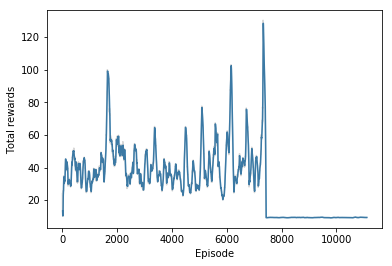

In [61]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

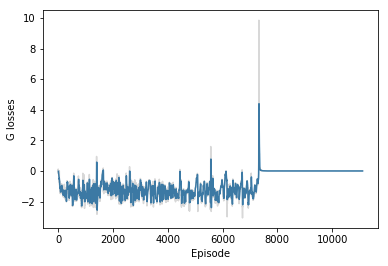

In [62]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

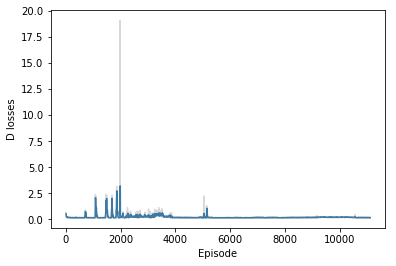

In [29]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.